# imports and global variables (see requirements.txt for dependencies)

In [1]:
# !pip install -r requirements.txt

import zipfile
import os
import pathlib

import gzip
from pathlib import Path

import pandas as pd
import numpy as np
import subprocess

import duckdb
import ipaddress
import time

from bs4 import BeautifulSoup
import requests
import urllib.request, urllib.error, urllib.parse
import sys
import radix
import io

import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium

from geopy import geocoders, distance
import geopy

from sklearn.neighbors import BallTree
from geopy import distance

import matplotlib.patches as patches


# constants
SPEED_IN_FIBRE = 299_792 / 1.467 # 1.467 refraction index fibre optics https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=949
ALPHA = 1
EARTH_RADIUS_KM = 6371 # Radius of Earth

# parameters
LATENCY_THRESHOLD = 3 # RTT maximum between latency neighbor hop and PoP
TRACEROUTE_MAX_LATENCY = 12 # RTT maximum between VP and PoP
DISK_DISTANCE_KM = 100 # airport grouping radius

DISK_DISTANCE_RAD = DISK_DISTANCE_KM / EARTH_RADIUS_KM # convert distance to radians



In [2]:
preprocess = True  # True -> preprocess data (converting individual Ark/scamper json files (converted using the warts2json) to parquet)

# Parse input data (.zip file with a .json.gz result for each VP)

In [3]:
zip_file_path = './data/ark_traceroutes.zip'
extract_directory = './out/'

if preprocess:
    try:
        # create dir if it does not yet exist
        output_path = pathlib.Path(extract_directory)
        output_path.mkdir(parents=True, exist_ok=True)

        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # get all file + path names in unzipped file
            all_members = zip_ref.infolist()
            member_paths = [m.filename for m in all_members]
            common_prefix = os.path.commonprefix(member_paths)

            # remove prefix paths in .zip
            prefix_to_strip = ""
            potential_prefix_dir = common_prefix.split('/')[0] + '/' # Check the first level dir
            prefix_to_strip = common_prefix
            print(f"Identified common prefix to strip: '{prefix_to_strip}'")

            # extract files
            for member_info in all_members:
                original_path_str = member_info.filename

                if not original_path_str or original_path_str == prefix_to_strip:
                    continue

                # Determine the relative path after stripping the prefix
                if prefix_to_strip and original_path_str.startswith(prefix_to_strip):
                    relative_path_str = original_path_str[len(prefix_to_strip):]
                else:
                    relative_path_str = original_path_str

                target_path = output_path / relative_path_str

                target_path.parent.mkdir(parents=True, exist_ok=True)
                # extract the file by reading from zip and writing to target
                with zip_ref.open(member_info) as source, open(target_path, "wb") as target:
                    target.write(source.read())

            print(f"Successfully extracted contents of '{zip_file_path}' to '{extract_directory}'")

    except FileNotFoundError:
        print(f"Error: Zip file not found at '{zip_file_path}'")
    except zipfile.BadZipFile:
        print(f"Error: Bad zip file '{zip_file_path}'. It might be corrupted.")
    except Exception as e:
        print(f"An unexpected error occurred during extraction: {e}")

Identified common prefix to strip: 'home/c4du/anycast_geo/results2/'
Successfully extracted contents of './data/ark_traceroutes.zip' to './out/'


In [4]:
# for each .json.gz file create a .parquet (with exploded traceroute hops)

json_pattern = '*.json.gz'
json_dir = Path(extract_directory)
parquet_dir = Path(extract_directory)

if preprocess:
    parquet_dir.mkdir(parents=True, exist_ok=True)

    # columns to keep
    base_cols_to_keep = [
        'monitor', 'dst', 'hop_count', 'probe_count', 'hops', 'stop_reason'
    ]

    # columns to keep within the 'hops' column (nested json, containing a result for each traceroute hop)
    hop_cols_to_keep_map = {
        'addr': 'string',
        'probe_ttl': 'int32',
        'rtt': 'float64',
        'reply_ttl': 'int32',
        'name': 'string'
    }

    columns_to_drop = [
        'type', 'version', 'userid', 'method', 'src', 'icmp_sum',
        'stop_reason', # dropped after filtering on COMPLETED traces
        'stop_data', 'start', 'attempts', 'hoplimit',
        'firsthop', 'wait', 'tos', 'probe_size'
    ]


    print(f"Starting JSON -> Parquet conversion...")
    start_conv_time = time.time()
    processed_files = 0
    failed_files = 0

    for json_file_path in json_dir.glob(json_pattern):
        print(f"Converting: {json_file_path.name}")
        try:
            # read json file
            temp_df = pd.read_json(json_file_path, lines=True, compression='gzip')
            temp_df = temp_df[temp_df['stop_reason'] == 'COMPLETED']

            if temp_df.empty:
                print(f"No traces for {json_file_path.name} with stop_reason 'COMPLETED'.")
                continue

            # filter out unwanted columns
            cols_to_select = [col for col in base_cols_to_keep if col in temp_df.columns]
            temp_df = temp_df[cols_to_select]

            # explode hops
            temp_df = temp_df.explode('hops', ignore_index=True)
            temp_df = temp_df.dropna(subset=['hops'])

            # normalize hops
            normalized_hops = pd.json_normalize(temp_df['hops'])
            normalized_hops.index = temp_df.index

            # create alias for each hop column
            final_hop_cols = {}
            for json_key, desired_type in hop_cols_to_keep_map.items():
                if json_key in normalized_hops.columns:
                     col_alias = f"hop_{json_key}"
                     final_hop_cols[col_alias] = normalized_hops[json_key]
            normalized_hops_selected = pd.DataFrame(final_hop_cols)

            # combine base and hop columns
            base_df_part = temp_df.drop(columns=['hops'])
            base_df_part = base_df_part.reset_index(drop=True)
            normalized_hops_selected = normalized_hops_selected.reset_index(drop=True)
            final_temp_df = pd.concat([base_df_part, normalized_hops_selected], axis=1)

            # rename 'monitor' to 'tx_hostname'
            final_temp_df = final_temp_df.rename(columns={'monitor': 'tx_hostname'})

            # drop unwanted columns
            cols_actually_present_to_drop = [col for col in columns_to_drop if col in final_temp_df.columns]
            final_temp_df = final_temp_df.drop(columns=cols_actually_present_to_drop, axis=1)

            # write to parquet
            parquet_file_name = json_file_path.stem.replace('.json', '') + '.parquet'
            output_path = parquet_dir / parquet_file_name
            final_temp_df.to_parquet(output_path, engine='pyarrow', compression='snappy', index=False)
            processed_files += 1

            # delete .json.gz
            json_file_path.unlink()

        except Exception as e:
            print(f"ERROR converting file {json_file_path.name}: {type(e).__name__} - {e}")
            failed_files += 1


    end_conv_time = time.time()
    print(f"\nConversion completed.")

    print(f"Processed {processed_files} files, failed {failed_files} files.")
    print(f"Total conversion time: {end_conv_time - start_conv_time:.2f} seconds")

Starting JSON -> Parquet conversion...
Converting: mru-mu.json.gz
Converting: bdl-us.json.gz
Converting: sjo-cr.json.gz
Converting: bwi3-us.json.gz
Converting: dar-tz.json.gz
Converting: aep3-ar.json.gz
Converting: arb3-us.json.gz
Converting: pdx-us.json.gz
Converting: abz2-uk.json.gz
Converting: sav-us.json.gz
Converting: pct2-us.json.gz
Converting: lax6-us.json.gz
Converting: bcb-us.json.gz
Converting: hnl4-us.json.gz
Converting: mia3-us.json.gz
Converting: uln-mn.json.gz
Converting: dbu-us.json.gz
Converting: zrh3-ch.json.gz
Converting: atl5-us.json.gz
Converting: jnb3-za.json.gz
Converting: svo-ru.json.gz
Converting: hnl-us.json.gz
Converting: beg-rs.json.gz
Converting: mia-us.json.gz
Converting: gig-br.json.gz
Converting: smf2-us.json.gz
Converting: bos6-us.json.gz
Converting: cjj-kr.json.gz
Converting: ory7-fr.json.gz
Converting: ind-us.json.gz
Converting: nat-br.json.gz
Converting: lcy2-uk.json.gz
Converting: lhe-pk.json.gz
Converting: sin-sg.json.gz
Converting: hkg5-cn.json.gz


# Read in data and combine with external datasets

In [5]:
# # read all parquets as one
# parquet_pattern = '*.parquet'
# parquet_files = list(parquet_dir.glob(parquet_pattern))
#
# traceroutes_df = pd.read_parquet(parquet_files, engine='pyarrow') # engine='fastparquet'

# for reproducability we share a single combined parquet containing all traceroute results

traceroutes_df = pd.read_parquet('combined.parquet', engine='pyarrow') # engine='fastparquet'

traceroutes_df.head(10)

In [6]:
# # extract hop_name column for retrieving OI data
#
# unique_hop_addr = traceroutes_df['hop_addr'].dropna().unique()
# pd.DataFrame(unique_hop_addr).to_csv('./data/unique_hops.csv', index=False, header=False)


In [7]:
# add OpenINTEL PTR recrods to traceroute data

hop_names = pd.read_csv('./data/ptr_lookup.csv')

traceroutes_df = pd.merge(traceroutes_df, hop_names, how='left', left_on='hop_addr', right_on='ip4_address')

# rename ptr_name to hop_name
traceroutes_df = traceroutes_df.rename(columns={'ptr_name': 'hop_name'})

In [8]:
# load in MAnycastR census data

census = pd.read_csv('./data/IPv4_full_19_04.csv.gz', compression='gzip') #  data from 2025 April 19
census = census[census['iGreedyICMPv4'] > 1] # filter on iGreedy confirmed anycast

census

,prefix,MAnycastICMPv4,MAnycastTCPv4,MAnycastUDPv4,iGreedyICMPv4,iGreedyTCPv4
1,1.0.0.0/24,27,27,26,71,28
136,1.1.1.0/24,28,28,27,71,28
229,1.10.10.0/24,1,0,1,3,0
2081,1.12.0.0/24,5,0,4,5,0
2082,1.12.12.0/24,3,1,0,3,1
...,...,...,...,...,...,...
4157838,99.83.254.0/24,25,0,0,49,0
4157839,99.83.255.0/24,25,0,0,49,0
4159680,99.99.97.0/24,2,1,2,2,1
4159681,99.99.98.0/24,2,0,2,2,0


In [9]:
# add prefix column

traceroutes_df['prefix'] = traceroutes_df['dst'].apply(lambda x: '.'.join(x.split('.')[:3]) + '.0/24')

In [10]:
# filter traceroutes by those confirmed using iGreedy (we filter out MAncyast2 candidate anycast targets as we do not consider traceroute as an anycast detection technique)

traceroutes_df = traceroutes_df[traceroutes_df['prefix'].isin(census['prefix'])]

In [11]:
# read in locations of Ark VPs
ark_locs = pd.read_csv('./data/arklocs.txt', header=None, names=['tx_hostname', 'vp_lat', 'vp_lon', 'tx_city', 'vp_asn'])
ark_locs['tx_hostname'] = ark_locs['tx_hostname'].str.split(".ark.caida.org").str[0]
ark_locs['vp_asn'] = ark_locs['vp_asn'].apply(lambda x: '-' if pd.isna(x) else str(int(float(x))))
ark_locs['tx_airport'] = ark_locs['tx_hostname'].str[:3]

# TODO fill missing ASN values of Ark VPs
ark_locs

,tx_hostname,vp_lat,vp_lon,tx_city,vp_asn,tx_airport
0,hlz2-nz,-37.79,175.28,Hamilton,9500,hlz
1,hkg4-cn,22.36,114.12,Hong Kong,212238,hkg
2,lax4-us,33.92,-118.39,Los Angeles,212238,lax
3,bfi-us,47.61,-122.33,Seattle,209,bfi
4,drs-de,51.03,13.73,Dresden,680,drs
...,...,...,...,...,...,...
269,ixc-in,30.34,76.38,Patiala,9829,ixc
270,mnl-ph,14.68,121.04,Quezon City,9821,mnl
271,arb3-us,42.23,-83.73,Ann Arbor,237,arb
272,hel-fi,60.21,24.65,Helsinki,-,hel


In [54]:
# how many distinct ASes?

ark_locs['vp_asn'].nunique()

178

In [55]:
# how many distinct cities?

ark_locs['tx_city'].nunique(0)

205

In [58]:
ark_locs['country_code'] = ark_locs['tx_hostname'].str.split("-").str[1]
ark_locs['country_code'].nunique()

66

In [59]:
# drop country code

ark_locs.drop(columns='country_code', inplace=True)

In [12]:
# add ark locations
traceroutes_df['tx_hostname'] = traceroutes_df['tx_hostname'].str.split(".ark.caida.org").str[0]
traceroutes_df = pd.merge(traceroutes_df, ark_locs, on='tx_hostname', how='left')

traceroutes_df

,tx_hostname,dst,hop_count,probe_count,hop_addr,hop_probe_ttl,hop_rtt,hop_reply_ttl,ip4_address,hop_name,prefix,vp_lat,vp_lon,tx_city,vp_asn,tx_airport
0,aep3-ar,1.0.0.0,9,13,192.168.1.1,1,1.281,64,NaN,NaN,1.0.0.0/24,-34.6,-58.38,Buenos Aires,7303,aep
1,aep3-ar,1.0.0.0,9,13,192.168.0.1,2,1.606,63,NaN,NaN,1.0.0.0/24,-34.6,-58.38,Buenos Aires,7303,aep
2,aep3-ar,1.0.0.0,9,13,181.96.113.217,7,13.811,249,181.96.113.217,host217.181-96-113.telecom.net.ar.,1.0.0.0/24,-34.6,-58.38,Buenos Aires,7303,aep
3,aep3-ar,1.0.0.0,9,13,181.13.127.254,8,9.127,248,181.13.127.254,host254.181-13-127.telecom.net.ar.,1.0.0.0/24,-34.6,-58.38,Buenos Aires,7303,aep
4,aep3-ar,1.0.0.0,9,13,1.0.0.0,9,12.355,56,NaN,NaN,1.0.0.0/24,-34.6,-58.38,Buenos Aires,7303,aep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27245217,oak5-us,192.228.88.1,20,29,129.250.2.119,12,112.257,242,129.250.2.119,ae-5.r26.osakjp02.jp.bb.gin.ntt.net.,192.228.88.0/24,37.8,-122.27,Oakland,46375,oak
27245218,oak5-us,192.228.88.1,20,29,129.250.2.66,14,182.119,239,129.250.2.66,ae-7.r24.sngpsi07.sg.bb.gin.ntt.net.,192.228.88.0/24,37.8,-122.27,Oakland,46375,oak
27245219,oak5-us,192.228.88.1,20,29,129.250.6.65,15,190.610,239,129.250.6.65,ae-15.a03.sngpsi07.sg.bb.gin.ntt.net.,192.228.88.0/24,37.8,-122.27,Oakland,46375,oak
27245220,oak5-us,192.228.88.1,20,29,116.51.18.134,16,184.926,238,116.51.18.134,ae-0.constant-company.sngpsi07.sg.bb.gin.ntt.net.,192.228.88.0/24,37.8,-122.27,Oakland,46375,oak


# exploratory data analysis

In [13]:
# how many VPs participated?

traceroutes_df['tx_hostname'].nunique()

274

In [14]:
# how many ASes are these in?

traceroutes_df['vp_asn'].nunique()

178

In [15]:
# how many targets did we measure?

traceroutes_df['dst'].nunique()

13735

In [16]:
# how many tx_hostname, dst pairs (i.e., how many traceroutes?)

traceroutes_df[['tx_hostname', 'dst']].drop_duplicates().shape[0]

3354073

In [17]:
# what is the average number of VPs that completed a traceroute towards a target

traceroutes_df.groupby('dst')['tx_hostname'].nunique().mean()


244.19898070622497

In [18]:
# what is the average number of hops captured?

traceroutes_df.groupby(['tx_hostname', 'dst']).size().mean()

8.123025944873591

In [19]:
# how many unique hop addresses?

traceroutes_df['hop_addr'].nunique()

99393

In [20]:
# how many unique hop addresses have PTR records?

traceroutes_df[~traceroutes_df['hop_name'].isna()]['hop_addr'].nunique()

45106

In [21]:
# how many hops have PTR records?

(~traceroutes_df['hop_name'].isna()).sum()

14336720

In [22]:
# how many hops do not have PTR records?

traceroutes_df['hop_name'].isna().sum()

12908502

In [23]:
 # how many unique PTR records did we observe?
traceroutes_df['hop_name'].nunique()

41758

# Calculate distances and RTTS

In [24]:
# get RTT to the PoP for each traceroute

dst_hops_df = traceroutes_df[traceroutes_df['dst'] == traceroutes_df['hop_addr']]

dst_hops_df = dst_hops_df[['tx_hostname', 'dst', 'hop_rtt']].rename(
    columns={'hop_rtt': 'pop_rtt'}
)
dst_hops_df = dst_hops_df.sort_values(by='pop_rtt').drop_duplicates(subset=['tx_hostname', 'dst']) # remove duplicate RTTs observed between an (Ark, PoP) pair -> keep the lowest RTT

traceroutes_df = pd.merge(traceroutes_df, dst_hops_df, on=['tx_hostname', 'dst'], how='left')

In [25]:
def rtt_to_distance(rtt_ms):
    one_way_time_s = (rtt_ms / 10_00) / 2  # to seconds and divide by 2 to get one-way latency
    distance_km = one_way_time_s * SPEED_IN_FIBRE
    return distance_km

In [26]:
# calculate distance between VP and hop
traceroutes_df['ark_to_hop'] = traceroutes_df['hop_rtt'].apply(rtt_to_distance)

# calculate distance between VP and PoP
traceroutes_df['ark_to_pop'] = traceroutes_df['pop_rtt'].apply(rtt_to_distance)

# calculate distance between hop and PoP
#traceroutes_df['hop_to_pop'] = np.maximum(0, result_df['ark_to_pop'] - result_df['ark_to_hop']) # this value is meaningless as the delta RTT between the two is unreliable

# load in ipinfo data

In [27]:
# load in ipinfo data (weekly snapshots)

def ipv4_to_uint32(ip_str):
    """Converts an IPv4 string to an unsigned 32-bit integer."""
    if ip_str is None:
        return None
    try:
        # Convert to IPv4Address object first to validate
        ip_obj = ipaddress.ip_address(ip_str)
        if ip_obj.version == 4:
            return int(ip_obj) # Returns the integer representation
        else:
            return None # Not an IPv4 address
    except ValueError:
        # Handle cases where the string is not a valid IP address at all
        return None

# load data in duck DB
db_file = 'ip_locations_ipv4.duckdb'
table_name = 'locations_ipv4'
json_file = './data/2025-03-31_standard_location.json.gz' # monthly snapshot

# if db_file exists, we are done
if os.path.exists(db_file):
    print(f"Database file {db_file} already exists. Skipping loading.")
else:
    print(f"Loading IPv4 ipinfo data from {json_file} into DuckDB table {table_name}")
    start_time = time.time()

    # create the database file
    con = duckdb.connect(database=db_file, read_only=False)

    # add ipv4 translation function to duckdb
    con.create_function('ipv4_to_uint32_udf', ipv4_to_uint32, [duckdb.typing.VARCHAR], duckdb.typing.UINTEGER)

    # create table schema
    con.execute(f"""
        DROP TABLE IF EXISTS {table_name};
        CREATE TABLE {table_name} (
            start_ip_str VARCHAR,
            end_ip_str VARCHAR,
            join_key VARCHAR,
            city VARCHAR,
            region VARCHAR,
            country VARCHAR,
            latitude DOUBLE,
            longitude DOUBLE,
            postal_code VARCHAR,
            timezone VARCHAR,
            start_ip_uint32 UINTEGER,
            end_ip_uint32 UINTEGER
        );
    """)

    # load in data (excluding ipv6 addresses)
    try:
        con.execute(f"""
            INSERT INTO {table_name} (
                start_ip_str, end_ip_str, join_key, city, region, country,
                latitude, longitude, postal_code, timezone,
                start_ip_uint32, end_ip_uint32
            )
            SELECT
                start_ip,
                end_ip,
                join_key,
                city,
                region,
                country,
                CAST(latitude AS DOUBLE),
                CAST(longitude AS DOUBLE),
                postal_code,
                timezone,
                ipv4_to_uint32_udf(start_ip) AS start_ip_u32,
                ipv4_to_uint32_udf(end_ip) AS end_ip_u32
            FROM read_json_auto('{json_file}', filename=true)
            WHERE
                -- filter out non-ipv4 addresses
                start_ip LIKE '%.%.%.%' AND start_ip NOT LIKE '%:%' AND
                end_ip LIKE '%.%.%.%'   AND end_ip   NOT LIKE '%:%'
        """)
    except Exception as e:
        print(f"An error occurred during INSERT: {e}")
        con.close()
        raise

    print("Creating index on IP ranges...")
    con.execute(f"CREATE INDEX ip_range_idx_u32 ON {table_name} (start_ip_uint32, end_ip_uint32);")
    con.close()

    end_time = time.time()
    print(f"IPInfo (IPV4) Database creation took: {end_time - start_time:.2f} seconds")

Database file ip_locations_ipv4.duckdb already exists. Skipping loading.


In [28]:
# get unique addresses
unique_addr = traceroutes_df['hop_addr'].dropna().unique()
print(f"Found {len(unique_addr)} unique hop addresses out of {len(traceroutes_df)} total hops.")

# get u32 values for lookup
addr_data = []
for hop in unique_addr:
    ip_uint32 = ipv4_to_uint32(hop)
    if ip_uint32 is not None: # Keep only valid IPv4 conversions
        addr_data.append({'hop_addr': hop, 'hop_addr_uint32': ip_uint32})

unique_addr_df = pd.DataFrame(addr_data)
unique_addr_df['hop_addr_uint32'] = unique_addr_df['hop_addr_uint32'].astype('uint32')

del unique_addr
del addr_data

Found 99393 unique hop addresses out of 27245222 total hops.


In [29]:
columns_to_load = [
    'city',
    'latitude',
    'longitude',
    'start_ip_uint32',
    'end_ip_uint32'
]
select_cols_str = ", ".join(columns_to_load)

dtypes_to_load = {
    'city': 'string',
    'latitude': 'float32',
    'longitude': 'float32',
    'start_ip_uint32': 'uint32',
    'end_ip_uint32': 'uint32'
}


print(f"Loading selected columns from {table_name} into Pandas...")
start_load_time = time.time()
con = None

try:
    con = duckdb.connect(database=db_file, read_only=True)
    print("  Connected to DuckDB.")

    # cast df
    select_expressions = []
    for col in columns_to_load:
        dtype = dtypes_to_load.get(col)
        if dtype:
            # data types
            sql_type = dtype.replace('string', 'VARCHAR') \
                            .replace('float32', 'FLOAT') \
                            .replace('float64', 'DOUBLE') \
                            .replace('uint32', 'UINTEGER') \
                            .replace('Int64', 'BIGINT')
            select_expressions.append(f"CAST({col} AS {sql_type}) AS {col}")
        else:
            select_expressions.append(col)

    select_query_cols_str = ",\n    ".join(select_expressions)

    query = f"""
    SELECT
        {select_query_cols_str}
    FROM {table_name}
    WHERE start_ip_uint32 IS NOT NULL -- exclude NaN values
    ORDER BY start_ip_uint32 ASC; -- sort by start_ip_uint32
    """

    ipinfo_df = con.execute(query).fetchdf()
    print(f"Successfully loaded {len(ipinfo_df)} rows.")

except Exception as e:
    print(f"An error occurred loading data from DuckDB: {e}")
finally:
    if con:
        con.close()
        print("  DuckDB connection closed.")

end_load_time = time.time()

print(f"\nLoading and initial sorting took: {end_load_time - start_load_time:.2f} seconds")
print("\nLoaded ip2location DataFrame Info:")
ipinfo_df.info(memory_usage='deep') # Check memory usage

Loading selected columns from locations_ipv4 into Pandas...
  Connected to DuckDB.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Successfully loaded 27274159 rows.
  DuckDB connection closed.

Loading and initial sorting took: 6.05 seconds

Loaded ip2location DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27274159 entries, 0 to 27274158
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   city             object 
 1   latitude         float32
 2   longitude        float32
 3   start_ip_uint32  uint32 
 4   end_ip_uint32    uint32 
dtypes: float32(2), object(1), uint32(2)
memory usage: 2.1 GB


In [30]:
# filter out bogons

BOGON_RANGES_CIDR = [
    "0.0.0.0/8",          # Current network (RFC 6890) - Often treated as bogon
    "10.0.0.0/8",         # Private Use (RFC 1918)
    "100.64.0.0/10",      # Shared Address Space (RFC 6598)
    "127.0.0.0/8",        # Loopback (RFC 6890)
    "169.254.0.0/16",     # Link-Local (RFC 3927)
    "172.16.0.0/12",      # Private Use (RFC 1918)
    "192.0.0.0/24",       # IETF Protocol Assignments (RFC 6890)
    "192.0.2.0/24",       # TEST-NET-1 (RFC 5737)
    "192.88.99.0/24",     # 6to4 Relay Anycast (Deprecated but often blocked, RFC 7526)
    "192.168.0.0/16",     # Private Use (RFC 1918)
    "198.18.0.0/15",      # Network Interconnect Device Benchmark Testing (RFC 2544)
    "198.51.100.0/24",    # TEST-NET-2 (RFC 5737)
    "203.0.113.0/24",     # TEST-NET-3 (RFC 5737)
    "224.0.0.0/4",        # Multicast (RFC 5771)
    "240.0.0.0/4",        # Reserved for Future Use (RFC 1112)
]

# get u32 ranges of bogons
BOGON_INT_RANGES = []
for cidr in BOGON_RANGES_CIDR:
    network = ipaddress.ip_network(cidr, strict=False)
    start_int = int(network.network_address)
    end_int = int(network.broadcast_address)
    BOGON_INT_RANGES.append((start_int, end_int))

print(f"Defined {len(BOGON_INT_RANGES)} bogon integer ranges.\n")


def filter_bogons_uint32(df: pd.DataFrame, ip_column_name: str) -> pd.DataFrame:
    """
    Filters a DataFrame to remove rows where the uint32 IP address falls
    within defined bogon ranges.
    """
    if ip_column_name not in df.columns:
        raise ValueError(f"Column '{ip_column_name}' not found in DataFrame.")

    if not pd.api.types.is_numeric_dtype(df[ip_column_name]):
         raise TypeError(f"Column '{ip_column_name}' must be a numeric type (ideally uint32).")

    print(f"Filtering bogons in column '{ip_column_name}'...")
    initial_rows = len(df)

    bogon_mask = pd.Series(False, index=df.index)
    ip_series = df[ip_column_name]

    # if the address is in any bogon range, return true
    for start_int, end_int in BOGON_INT_RANGES:
        in_range_mask = ip_series.between(start_int, end_int)
        bogon_mask |= in_range_mask

    num_bogons = bogon_mask.sum()
    num_valid = initial_rows - num_bogons

    print(f"Initial rows: {initial_rows}")
    print(f"Bogon addresses identified: {num_bogons}")
    print(f"Non-bogon addresses remaining: {num_valid}")

    # return non bogon addresses
    df_filtered = df[~bogon_mask]

    return df_filtered

unique_addr_df = filter_bogons_uint32(unique_addr_df, 'hop_addr_uint32')

Defined 15 bogon integer ranges.

Filtering bogons in column 'hop_addr_uint32'...
Initial rows: 99393
Bogon addresses identified: 6282
Non-bogon addresses remaining: 93111


In [31]:
# unique hop addresses df

unique_addr_df = unique_addr_df.sort_values('hop_addr_uint32').reset_index(drop=True)

# add location information
unique_addr_df = pd.merge_asof(
    unique_addr_df,
    ipinfo_df,
    left_on='hop_addr_uint32',
    right_on='start_ip_uint32',
    direction='backward'
)

In [32]:
cols_to_merge = ['hop_addr', 'city', 'latitude', 'longitude']

# add location data to full dataset
traceroutes_df = pd.merge(
    traceroutes_df,
    unique_addr_df[cols_to_merge],
    on='hop_addr',
    how='left'
)

rename_map = {
    "city": "ipinfo_city",
    "latitude": "ipinfo_lat",
    "longitude": "ipinfo_lon"
}

traceroutes_df = traceroutes_df.rename(columns=rename_map)

In [33]:
# how many hops have IPInfo locations?

(~traceroutes_df['ipinfo_city'].isna()).sum()

24412016

In [34]:
# how many hops have no IPInfo locations (i.e., bogons)?

traceroutes_df['ipinfo_city'].isna().sum()

2833206

# Get ASN data

In [35]:
def find_day_url_v4():
    #https://data.caida.org/datasets/routing/routeviews-prefix2as/2025/04/routeviews-rv2-20250418-1200.pfx2as.gz
    base_url = 'http://data.caida.org/datasets/routing/routeviews-prefix2as/{}/{:02d}'.format(2025, 4)
    daymask = '{}{:02d}{:02d}'.format(2025, 4, 19)
    dayurl = None
    try:
        page = requests.get(base_url, timeout=10).text
        soup = BeautifulSoup(page, 'html.parser')
        for node in soup.find_all('a'):
            href = node.get('href')
            if href and href.endswith('pfx2as.gz'):
                find_dayurl = f"{base_url}/{href}" # Construct full URL
                if daymask in find_dayurl:
                    dayurl = find_dayurl
                    break
    except requests.exceptions.RequestException as e:
        print(f"Error fetching CAIDA directory page {base_url}: {e}")
        sys.exit(99)

    if dayurl is None:
        print('Unable to find day-specific URL for {}'.format(day.isoformat()))
        sys.exit(99)
    return dayurl

In [36]:
# adds ASN and BGP prefix from CAIDA data to a csv with ipaddresses
def fetch_caida_data_as_radix():
    caida_url = find_day_url_v4()
    caida_radix = radix.Radix()

    try:
        sys.stdout.write('Retrieving {} ... '.format(caida_url))
        sys.stdout.flush()
        #
        # # Retrieve gzipped file

        # Read the response as bytes

        response = urllib.request.urlopen(caida_url)
        gzFile = io.BytesIO()
        gzFile.write(response.read())

        print('OK')
    except os.error as err:
        print('Failed to download or parse {}'.format(caida_url))
        print(err)
        sys.exit(99)

    gzFile.seek(0, os.SEEK_END)
    print('Read {} bytes of compressed data'.format(gzFile.tell()))
    gzFile.seek(0, os.SEEK_SET)

    # Iterate over decompressed content
    pfx2as = gzip.GzipFile(fileobj=gzFile, mode='rb')

    pfx_count = 0

    for line in pfx2as:
        line = line.decode('utf-8')

        line = line.rstrip('\n')

        caida_vals = line.split('\t')

        if len(caida_vals) != 3:
            print('Invalid line in data retrieved from CAIDA ({})'.format(line))

        prefix = '{}/{}'.format(caida_vals[0], caida_vals[1])
        asn = caida_vals[2]


        rnode = caida_radix.add(prefix)
        rnode.data["AS"] = asn

        pfx_count += 1

        if (pfx_count % 100000) == 0:
            sys.stdout.write('+')
            sys.stdout.flush()
        elif (pfx_count % 10000) == 0:
            sys.stdout.write('-')
            sys.stdout.flush()

    pfx2as.close()

    print()
    print('Processed {} prefixes'.format(pfx_count))

    return caida_radix

In [37]:
print(f"\nFound {len(unique_addr_df)} unique non-null IP strings to look up.") # unique hop addresses, excluding bogons


if 'lookup_radix4' not in locals():
    lookup_radix4 = fetch_caida_data_as_radix()

# perform lookup
print(f"\nPerforming {len(unique_addr_df)} lookups in Radix tree...")
start_lookup_time = time.time()
lookup_results = []
successful_lookups = 0
failed_lookups = 0

for ip in unique_addr_df['hop_addr']:
    try:
        # search_best finds the longest matching prefix
        rnode = lookup_radix4.search_best(ip)
        if rnode: # Check if a node was found
            lookup_results.append({
                'hop_addr': ip, # The IP we looked up
                'hop_asn': rnode.data.get('AS', '-'), # Get AS, default to '-'
            })
            successful_lookups += 1
        else:
            # No matching prefix found in the tree
            lookup_results.append({'hop_addr': ip, 'hop_asn': '-'})
            failed_lookups += 1
    except ValueError: # Handle invalid IP format errors from radix lookup
         lookup_results.append({'hop_addr': ip, 'hop_asn': '-'})
         if failed_lookups < 10: print(f"Radix lookup failed for invalid IP format: {ip}")
         failed_lookups += 1
    except Exception as lookup_err: # Catch other potential errors
         lookup_results.append({'hop_addr': ip, 'hop_asn': '-'})
         if failed_lookups < 10: print(f"Radix lookup failed for {ip}: {lookup_err}")
         failed_lookups += 1

end_lookup_time = time.time()
print(f"Lookups completed in {end_lookup_time - start_lookup_time:.2f} seconds.")
print(f"  Successful: {successful_lookups}")
print(f"  Failed/Not Found: {failed_lookups}")

asn_df = pd.DataFrame(lookup_results)

print("\nMerging ASN/Prefix data back into the original DataFrame...")

# drop hop_asn if it already exists
if 'hop_asn' in traceroutes_df.columns:
    traceroutes_df = traceroutes_df.drop(columns=['hop_asn'])

traceroutes_df = pd.merge(
    traceroutes_df,
    asn_df[['hop_addr', 'hop_asn']],
    on='hop_addr',
    how='left'
)

# unknown ASes have value '-'
traceroutes_df['hop_asn'].fillna('-', inplace=True)
print("Merge complete.")


Found 93111 unique non-null IP strings to look up.
Retrieving http://data.caida.org/datasets/routing/routeviews-prefix2as/2025/04/routeviews-rv2-20250419-0800.pfx2as.gz ... OK
Read 3585254 bytes of compressed data
---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---
Processed 1035774 prefixes

Performing 93111 lookups in Radix tree...
Lookups completed in 9.83 seconds.
  Successful: 84677
  Failed/Not Found: 8434

Merging ASN/Prefix data back into the original DataFrame...


/var/folders/k_/b2zc8kg571bcqh2l9j8mj82h0000gn/T/ipykernel_37688/2055499213.py:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  traceroutes_df['hop_asn'].fillna('-', inplace=True)


Merge complete.


In [38]:
# how many ASes in the dataset?

traceroutes_df['hop_asn'].nunique()

1827

In [39]:
# how many source ASNs?

ark_locs['vp_asn'].nunique()

178

# PTR record translation (Hoiho)

In [40]:
# configuration files
ptr_records_file = './data/ptr_records.csv'
hoiho_script = './data/hoiho/hoiho-apply.pl'
hoiho_db = './data/hoiho/2024-08.midar-iff.geo-re.jsonl'

# store unique PTR records
print(f"\nSaving unique PTR records to {ptr_records_file}...")
traceroutes_df['hop_name'] = traceroutes_df['hop_name'].str.rstrip('.') # OI data has a trailing dot
unique_hop_names = traceroutes_df['hop_name'].unique()
pd.DataFrame(unique_hop_names).to_csv(ptr_records_file, index=False, header=False)
print(f"Saved {len(unique_hop_names)} unique names.")

# Check if required files/scripts exist before running
if not os.path.exists(hoiho_script):
     print(f"ERROR: Hoiho script not found at '{hoiho_script}'")
elif not os.path.exists(hoiho_db):
     print(f"ERROR: Hoiho database not found at '{hoiho_db}'")
elif not os.path.exists(ptr_records_file):
     print(f"ERROR: Input PTR file not found at '{ptr_records_file}'")
else:
    print(f"\nExecuting Hoiho Perl script: {hoiho_script}...")
    command = f"cat {ptr_records_file} | perl {hoiho_script} {hoiho_db}"
    try:
        # run perl command
        process_result = subprocess.run(
            command,
            shell=True,
            capture_output=True,
            text=True,
            check=True
        )

        # Get the standard output from the completed process
        ptr_translations_content = process_result.stdout
        print(f"Perl script executed successfully. Output length: {len(ptr_translations_content)} chars.")

        # Check for errors printed to stderr
        if process_result.stderr:
             print("\n--- Warnings/Errors from Perl script (stderr) ---")
             print(process_result.stderr)
             print("-------------------------------------------------")

        print("\nLoading PTR translations from script output...")
        if ptr_translations_content:
            ptr_map = pd.read_csv(
                io.StringIO(ptr_translations_content),
                sep=' ',
                on_bad_lines='skip',
                names=['hop_name', 'location', 'code', 'ptr_lat', 'ptr_lon', 'ptr_city'],
                skipinitialspace=True
            )
            print(f"Loaded {len(ptr_map)} translation entries.")
        else:
            print("Warning: Perl script produced no output. PTR map will be empty.")
            ptr_map = pd.DataFrame(columns=['hop_name', 'location', 'code', 'ptr_lat', 'ptr_lon', 'ptr_city'])


    except FileNotFoundError:
        print(f"ERROR: 'perl' command not found. Is Perl installed and in your system's PATH?")
    except subprocess.CalledProcessError as e:
        print(f"ERROR: Perl script execution failed with exit code {e.returncode}.")
        print("--- Perl script STDOUT ---")
        print(e.stdout)
        print("--- Perl script STDERR ---")
        print(e.stderr)
    except Exception as e:
        print(f"An unexpected error occurred during subprocess execution: {e}")

print("\nMerging PTR translations into final DataFrame...")
cols_to_merge = ['hop_name', 'ptr_lat', 'ptr_lon', 'ptr_city']

traceroutes_df = pd.merge(
    traceroutes_df,
    ptr_map[cols_to_merge],
    on='hop_name',
    how='left'
)
print("Merge complete.")


Saving unique PTR records to ./data/ptr_records.csv...
Saved 41759 unique names.

Executing Hoiho Perl script: ./data/hoiho/hoiho-apply.pl...
Perl script executed successfully. Output length: 1452294 chars.

--- Warnings/Errors from Perl script (stderr) ---
Use of uninitialized value in printf at ./data/hoiho/hoiho-apply.pl line 165, <STDIN> line 18677.
Use of uninitialized value in printf at ./data/hoiho/hoiho-apply.pl line 165, <STDIN> line 18849.

-------------------------------------------------

Loading PTR translations from script output...
Loaded 19613 translation entries.

Merging PTR translations into final DataFrame...
Merge complete.


In [41]:
# how many PTR records have a city location?

(~ptr_map['ptr_city'].isna()).sum()

16565

In [42]:
# how many PTR records have no city location?

ptr_map['ptr_city'].isna().sum()

3048

In [43]:
# how many hops have PTR city locations?

(~traceroutes_df['ptr_city'].isna()).sum()

3340097

In [44]:
# how many hops have NO PTR city locations?

(traceroutes_df['ptr_city'].isna()).sum()

23905125

# Validate hop locations

In [45]:
# loc_valid

# calculate distance between 'vp_lat', 'vp_lon' and 'latitude', 'longitude'
# verify distance is smaller than 'ark_to_hop' (which is in km)

def haversine_vectorized(lat1, lon1, lat2, lon2, earth_radius_km=6371):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees), returning distance in kilometers.
    Vectorized version for Pandas Series.
    """
    # Convert decimal degrees to radians
    lat1 = pd.to_numeric(lat1, errors='coerce')
    lon1 = pd.to_numeric(lon1, errors='coerce')
    lat2 = pd.to_numeric(lat2, errors='coerce')
    lon2 = pd.to_numeric(lon2, errors='coerce')

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Use arctan2 for numerical stability
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance_km = earth_radius_km * c
    return distance_km

### verify IPinfo locations
# calculate distance
traceroutes_df['calculated_distance_km'] = haversine_vectorized(
    traceroutes_df['vp_lat'],
    traceroutes_df['vp_lon'],
    traceroutes_df['ipinfo_lat'],
    traceroutes_df['ipinfo_lon']
)


# distance between points must be less than the maximum distance travelled given the latency difference
traceroutes_df['ipinfo_loc_valid'] = traceroutes_df['calculated_distance_km'] < traceroutes_df['ark_to_hop']


### verify PTR record locations
traceroutes_df['calculated_distance_km'] = haversine_vectorized(
    traceroutes_df['vp_lat'],
    traceroutes_df['vp_lon'],
    traceroutes_df['ptr_lat'],
    traceroutes_df['ptr_lon']
)

traceroutes_df['ptr_loc_valid'] = traceroutes_df['calculated_distance_km'] < traceroutes_df['ark_to_hop']

traceroutes_df.drop(columns=['calculated_distance_km'], inplace=True)

# ptr valids

valid_count = traceroutes_df['ptr_loc_valid'].sum()
total_count = (~traceroutes_df['ptr_city'].isna()).sum()

print(f"PTR locations {valid_count} valid out of {total_count}")

# ipinfo valids

valid_count = traceroutes_df['ipinfo_loc_valid'].sum()
total_count = (~traceroutes_df['ipinfo_city'].isna()).sum()

print(f"IPInfo locations {valid_count} valid out of {total_count}")

either_valid = (traceroutes_df['ptr_loc_valid'] | traceroutes_df['ipinfo_loc_valid']).sum()
print(f"Locations with either PTR or IPInfo valid locations: {either_valid}")

PTR locations 3281087 valid out of 3340097
IPInfo locations 20713439 valid out of 24412016
Locations with either PTR or IPInfo valid locations: 20795606


In [47]:
# how many unique hop addresses have a valid ipinfo location?

traceroutes_df[traceroutes_df['ipinfo_loc_valid']]['hop_addr'].nunique()

91890

In [48]:
# how many unique hop addresses have a valid PTR location?

traceroutes_df[traceroutes_df['ptr_loc_valid']]['hop_addr'].nunique()

16929

In [49]:
# how many unique hop address for ipinfo excluding those with ptr location

unique_ptr_loc_valid = traceroutes_df[traceroutes_df['ptr_loc_valid']]['hop_addr'].unique()

unique_ip_info_valid = traceroutes_df[traceroutes_df['ipinfo_loc_valid']]['hop_addr'].unique()

only_in_ipinfo = np.setdiff1d(unique_ip_info_valid, unique_ptr_loc_valid)

len(only_in_ipinfo)

75143

In [52]:

in_both = np.intersect1d(unique_ptr_loc_valid, unique_ip_info_valid)
len(in_both)

16747

In [53]:
union = np.union1d(unique_ptr_loc_valid, unique_ip_info_valid)
len(union)

92072

In [87]:
# get preferred locations (ptr if valid, else ipinfo if valid, else NaN)

conditions = [
    traceroutes_df['ptr_loc_valid'] == True,
    traceroutes_df['ipinfo_loc_valid'] == True
]

# For hop_city
city_choices = [
    traceroutes_df['ptr_city'],
    traceroutes_df['ipinfo_city']
]
# For hop_lat
lat_choices = [
    traceroutes_df['ptr_lat'],
    traceroutes_df['ipinfo_lat']
]

lon_choices = [
    traceroutes_df['ptr_lon'],
    traceroutes_df['ipinfo_lon']
]

# get hop location info
traceroutes_df['hop_city'] = np.select(conditions, city_choices, default=pd.NA)
traceroutes_df['hop_lat'] = np.select(conditions, lat_choices, default=np.nan)
traceroutes_df['hop_lon'] = np.select(conditions, lon_choices, default=np.nan)

traceroutes_df = traceroutes_df.drop(columns=
    [
        'ipinfo_city', 'ipinfo_lat', 'ipinfo_lon',
        'ptr_city', 'ptr_lat', 'ptr_lon',
        'ptr_loc_valid', 'ipinfo_loc_valid'
    ]
)

print(f"no locations available {(traceroutes_df['hop_city'].isna()).sum()}")
print(f"locations available {(~traceroutes_df['hop_city'].isna()).sum()}")



no locations available 6449628
locations available 20795594


# Obtain results using 'latency neighbors'

In [90]:
# detect neighbors

print(f"Latency threshold for latency neighbors: {LATENCY_THRESHOLD} ms")

traceroutes_df['is_neighbor'] = abs(traceroutes_df['pop_rtt'] - traceroutes_df['hop_rtt']) < LATENCY_THRESHOLD

Latency threshold for latency neighbors: 3 ms


In [91]:
# for geolocating PoPs we only use VPs within 12ms of the anycast PoP
traceroutes_df_f = traceroutes_df[traceroutes_df['pop_rtt'] < TRACEROUTE_MAX_LATENCY]
traceroutes_df_f

,tx_hostname,dst,hop_count,probe_count,hop_addr,hop_probe_ttl,hop_rtt,hop_reply_ttl,ip4_address,hop_name,...,vp_asn,tx_airport,pop_rtt,ark_to_hop,ark_to_pop,hop_asn,hop_city,hop_lat,hop_lon,is_neighbor
0,aep3-ar,1.0.0.0,9,13,192.168.1.1,1,1.281,64,NaN,NaN,...,7303,aep,5.976,130.890781,610.619288,-,<NA>,NaN,NaN,False
1,aep3-ar,1.0.0.0,9,13,192.168.0.1,2,1.606,63,NaN,NaN,...,7303,aep,5.976,164.098825,610.619288,-,<NA>,NaN,NaN,False
2,aep3-ar,1.0.0.0,9,13,181.96.113.217,7,13.811,249,181.96.113.217,host217.181-96-113.telecom.net.ar,...,7303,aep,5.976,1411.188586,610.619288,7303,Buenos Aires,-34.613152,-58.377232,False
3,aep3-ar,1.0.0.0,9,13,181.13.127.254,8,9.127,248,181.13.127.254,host254.181-13-127.telecom.net.ar,...,7303,aep,5.976,932.584044,610.619288,7303,Ciudad del Libertador General San Martín,-34.577888,-58.538639,False
4,aep3-ar,1.0.0.0,9,13,1.0.0.0,9,12.355,56,NaN,NaN,...,7303,aep,5.976,1262.416551,610.619288,13335,<NA>,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27245190,oak5-us,192.188.22.6,14,20,75.101.33.185,7,2.236,249,75.101.33.185,100.ae1.nrd1.equinix-sj.sonic.net,...,46375,oak,4.146,228.471340,423.632458,46375,San Jose,37.339390,-121.894958,True
27245191,oak5-us,192.188.22.6,14,20,206.223.116.137,8,2.320,57,206.223.116.137,eqx-sj.es.net,...,46375,oak,4.146,237.054342,423.632458,-,San Jose,37.339390,-121.894958,True
27245192,oak5-us,192.188.22.6,14,20,198.129.100.30,12,4.476,53,198.129.100.30,lbnl59-cr6--esnetwest-se425.ip.es.net,...,46375,oak,4.146,457.351395,423.632458,292,San Jose,37.339390,-121.894958,True
27245193,oak5-us,192.188.22.6,14,20,198.129.100.29,13,4.431,243,198.129.100.29,site--esnetwest-se425.ip.es.net,...,46375,oak,4.146,452.753358,423.632458,292,San Jose,37.339390,-121.894958,True


In [92]:
# how many valid tx_hostname,dst pairs remain?

traceroutes_df_f[['tx_hostname', 'dst']].drop_duplicates().shape[0]

1705930

In [93]:
# how many valid dsts?

traceroutes_df_f['dst'].nunique()

13706

In [94]:
# find cases where the VP itself is a latency neighbor

print("Finding Ark VP latency neighbors")
is_dest_hop = traceroutes_df_f['dst'] == traceroutes_df_f['hop_addr']
is_fast_dest_hop = is_dest_hop & (traceroutes_df_f['hop_rtt'] < LATENCY_THRESHOLD)

fast_dest_df = traceroutes_df_f[is_fast_dest_hop]
fast_dest_results_list = fast_dest_df.apply(
    lambda row: pd.Series({
        'tx_hostname': row['tx_hostname'],
        'dst': row['dst'],
        'inferred_city': row['tx_city'],
        'vp_lat': row['vp_lat'],
        'vp_lon': row['vp_lon'],
        'hop_lat': row['vp_lat'], # use vp coords as hop coords
        'hop_lon': row['vp_lon']
    }), axis=1
).drop_duplicates().to_dict('records')
print(f"Found {len(fast_dest_results_list)} routes resolved by latency neighbor VPs")


fast_dest_results_df = pd.DataFrame(fast_dest_results_list)

Finding Ark VP latency neighbors
Found 939187 routes resolved by latency neighbor VPs


In [95]:
# Filter out hop == dst, to identify latency neighbor hops
hops_df_f = traceroutes_df_f[traceroutes_df_f['dst'] != traceroutes_df_f['hop_addr']]
print(f"DataFrame shape after removing all destination hops: {hops_df_f.shape}")

def find_closest_neighbor_data(group):
    """
    Finds the data (city, lat, lon, latitude, longitude) of the latency neighbor
    closest to the destination (highest TTL), ensuring the location is valid.
    Returns a Series with the required data or NAs.
    """
    # Filter on latency neighbors of the anycast address
    neighbors = group[group['is_neighbor'] == True]

    # Filter on neighbors with city geolocation data (already validated)
    valid_city_neighbors = neighbors.dropna(subset=['hop_city'])

    if not valid_city_neighbors.empty:
        # Get the neighbor location closest to the VP (lowest TTL)
        closest_neighbor_to_vp = valid_city_neighbors.sort_values('hop_probe_ttl', ascending=True).iloc[0]
        # we only use latency neighbors if there exists one within 9ms of the VP (to avoid false geolocations due to RTT noise)

        # no neighbor within 9ms
        if closest_neighbor_to_vp['hop_rtt'] > 9:  # TODO lowest TTL may have a higher TTL than next hops -> should we use the lowest neighbor RTT instead?
            return pd.Series({
                'inferred_city': pd.NA,
                'vp_lat': pd.NA,
                'vp_lon': pd.NA,
                'hop_lat': pd.NA,
                'hop_lon': pd.NA
            }, index=['inferred_city', 'vp_lat', 'vp_lon', 'hop_lat', 'hop_lon'])

        closest_neighbor_to_pop = valid_city_neighbors.sort_values('hop_probe_ttl', ascending=False).iloc[0]

        # return location
        return pd.Series({
            'inferred_city': closest_neighbor_to_pop['hop_city'],
            'vp_lat': closest_neighbor_to_pop['vp_lat'],
            'vp_lon': closest_neighbor_to_pop['vp_lon'],
            'hop_lat': closest_neighbor_to_pop['hop_lat'],
            'hop_lon': closest_neighbor_to_pop['hop_lon']
        })
    else:
        #nNo valid location found
        return pd.Series({
            'inferred_city': pd.NA,
            'vp_lat': pd.NA,
            'vp_lon': pd.NA,
            'hop_lat': pd.NA,
            'hop_lon': pd.NA
        }, index=['inferred_city', 'vp_lat', 'vp_lon', 'hop_lat', 'hop_lon'])

# Group by tx_hostname, dst pairs
print("\nApplying neighbor logic to remaining routes...")
neighbor_results_df = hops_df_f.groupby(
        ['tx_hostname', 'dst'], observed=True, dropna=False
        ).apply(find_closest_neighbor_data).reset_index()

# combine results
print("\nCombining results from VP latency neighbors and hop latency neighbor logic...")
# Concatenate the two sets of results
inferred_df = pd.concat([fast_dest_results_df, neighbor_results_df], ignore_index=True)

# Prioritize fast_dest_results_df over neighbor_results_df
inferred_df = inferred_df.drop_duplicates(subset=['tx_hostname', 'dst'], keep='first')

# remove NaNs
inferred_df = inferred_df[~inferred_df['inferred_city'].isna()]

inferred_df # may take a while

DataFrame shape after removing all destination hops: (10274463, 24)

Applying neighbor logic to remaining routes...


/var/folders/k_/b2zc8kg571bcqh2l9j8mj82h0000gn/T/ipykernel_22404/3940940963.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  neighbor_results_df = hops_df_f.groupby(



Combining results from VP latency neighbors and hop latency neighbor logic...


,tx_hostname,dst,inferred_city,vp_lat,vp_lon,hop_lat,hop_lon
0,dar-tz,192.31.196.1,Dar es Salaam,-6.79,39.21,-6.79,39.21
1,dar-tz,192.33.14.30,Dar es Salaam,-6.79,39.21,-6.79,39.21
2,dar-tz,192.58.128.30,Dar es Salaam,-6.79,39.21,-6.79,39.21
3,dar-tz,194.0.17.1,Dar es Salaam,-6.79,39.21,-6.79,39.21
4,dar-tz,194.0.27.12,Dar es Salaam,-6.79,39.21,-6.79,39.21
...,...,...,...,...,...,...,...
2641136,zrh4-ch,97.74.111.51,Zürich,47.38,8.54,47.366669,8.55
2641137,zrh4-ch,97.74.96.0,Zürich,47.38,8.54,47.366669,8.55
2641138,zrh4-ch,97.74.97.35,Zürich,47.38,8.54,47.366669,8.55
2641139,zrh4-ch,97.74.98.0,Zürich,47.38,8.54,47.366669,8.55


# Airport clustering

In [74]:
airport_df = pd.read_csv('./data/airports.csv', sep='\t')

print("--- Pre-processing Airport Data ---")
start_time = time.time()

# split coords
coords = airport_df['lat long'].str.split(' ', expand=True)
airport_df['a_lat'] = pd.to_numeric(coords[0], errors='coerce')
airport_df['a_lon'] = pd.to_numeric(coords[1], errors='coerce')
airport_df['a_heuristic'] = pd.to_numeric(airport_df['pop'].str.split(' ', expand=True)[0], errors='coerce')

# convert airport coords to radians
airport_df['a_lat_rad'] = np.radians(airport_df['a_lat'])
airport_df['a_lon_rad'] = np.radians(airport_df['a_lon'])

# numpy arrays for fast lookups
airport_coords_rad = airport_df[['a_lat_rad', 'a_lon_rad']].values
airport_heuristics = airport_df['a_heuristic'].values
airport_lat = airport_df['a_lat'].values
airport_lon = airport_df['a_lon'].values
airport_iata = airport_df['#IATA'].values
airport_name = airport_df['name'].values


print(f"Airport pre-processing took {time.time() - start_time:.2f}s")

airport_df


--- Pre-processing Airport Data ---
Airport pre-processing took 0.01s


,#IATA,size,name,lat long,country_code,city,pop,heuristic,1,2,3,a_lat,a_lon,a_heuristic,a_lat_rad,a_lon_rad
0,ASH,large_airport,Ashburn Airport,39.043611 -77.4875,US,Ashburn,43511 0 0 0,NaN,NaN,NaN,NaN,39.043611,-77.487500,43511,0.681440,-1.352412
1,AMX,large_airport,Amsterdam Airport Schiphol,52.3086013794 4.7638897896,NL,Amsterdam,741636 0 0 0,NaN,NaN,NaN,NaN,52.308601,4.763890,741636,0.912957,0.083146
2,AMS,large_airport,Amsterdam Airport Schiphol,52.3086013794 4.7638897896,NL,Amsterdam,741636 0 0 0,NaN,NaN,NaN,NaN,52.308601,4.763890,741636,0.912957,0.083146
3,AMZ,large_airport,Amsterdam Airport Schiphol,52.3086013794 4.7638897896,NL,Amsterdam,741636 0 0 0,NaN,NaN,NaN,NaN,52.308601,4.763890,741636,0.912957,0.083146
4,PIX,large_airport,San Francisco International Airport,37.6189994812 -122.375,US,San Francisco,805235 0 -122.389979 37.615223,NaN,NaN,NaN,NaN,37.618999,-122.375000,805235,0.656575,-2.135847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3023,CPM,large_airport,Los Angeles International Airport,33.94250107 -118.4079971,US,Los Angeles,3792621 0 0 0,NaN,NaN,NaN,NaN,33.942501,-118.407997,3792621,0.592408,-2.066609
3024,OXR,large_airport,Los Angeles International Airport,33.94250107 -118.4079971,US,Los Angeles,3792621 0 0 0,NaN,NaN,NaN,NaN,33.942501,-118.407997,3792621,0.592408,-2.066609
3025,RHV,medium_airport,Evelio Javier Airport,10.765999794 121.932998657,PH,San Jose,118807 2 0 0,NaN,NaN,NaN,NaN,10.766000,121.932999,118807,0.187902,2.128132
3026,STO,large_airport,Stockholm-Arlanda Airport,59.6519012451 17.9186000824,SE,Stockholm,1253309 0 0 0,NaN,NaN,NaN,NaN,59.651901,17.918600,1253309,1.041122,0.312739


In [82]:
# get inferred locations radian coordinates
inferred_df['hop_lat'] = pd.to_numeric(inferred_df['hop_lat'], errors='coerce')
inferred_df['hop_lon'] = pd.to_numeric(inferred_df['hop_lon'], errors='coerce')

inferred_df['hop_lat_rad'] = np.radians(inferred_df['hop_lat'])
inferred_df['hop_lon_rad'] = np.radians(inferred_df['hop_lon'])
inferred_coords_rad = inferred_df[['hop_lat_rad', 'hop_lon_rad']].values

inferred_coords_rad

array([[-0.11850786,  0.6843436 ],
       [-0.11850786,  0.6843436 ],
       [-0.11850786,  0.6843436 ],
       ...,
       [ 0.82670432,  0.14922565],
       [ 0.82670432,  0.14922565],
       [ 0.82670432,  0.14922565]])

In [84]:
# create ball tree
print("\n--- Building BallTree ---")
tree = BallTree(airport_coords_rad, metric='haversine')

print("\n--- Querying nearby airports using BallTree ---")
start_time = time.time()
# find distances (and indices) of airports within the radius
nearby_indices_list, nearby_distances_list_rad = tree.query_radius(
    inferred_coords_rad, r=DISK_DISTANCE_RAD, return_distance=True
)

nearby_distances_list_km = [dist_rad * EARTH_RADIUS_KM for dist_rad in nearby_distances_list_rad]
print(f"BallTree query_radius took {time.time() - start_time:.2f}s")


--- Building BallTree ---

--- Querying nearby airports using BallTree ---
BallTree query_radius took 7.39s


In [85]:
# fallback airports (closest airport)
print("\n--- Finding the absolute closest airport (fallback) ---")
start_time = time.time()
# query returns distances (in radians) and indices for the k=1 nearest neighbor
closest_dist_rad, closest_idx = tree.query(inferred_coords_rad, k=1)
# closest_dist_km = closest_dist_rad[:, 0] * EARTH_RADIUS_KM # Distances in km
closest_indices = closest_idx[:, 0] # Get the index array
print(f"BallTree query (k=1) took {time.time() - start_time:.2f}s")


--- Finding the absolute closest airport (fallback) ---
BallTree query (k=1) took 10.24s


In [86]:
results = []
print("\n--- Calculating heuristic for nearby airports ---")
start_time = time.time()

for i in range(len(inferred_coords_rad)): # iterate through all final latency neighbors
    # retrieve the airports within the radius, and their distance from the latency neighbor
    nearby_indices = nearby_indices_list[i]
    nearby_distances_km = nearby_distances_list_km[i]

    # retrieve fallback airport for this point
    fallback_idx = closest_indices[i]
    fallback_airport_details = {
        'lat': airport_lat[fallback_idx],
        'lon': airport_lon[fallback_idx],
        'name': airport_name[fallback_idx],
        'iata': airport_iata[fallback_idx]
    }

    # heuristic calculation
    best_p = -1.0
    best_idx_in_disk = -1 # -1 -> no suitable airport found with heuristic

    if len(nearby_indices) > 0:
        # Filter again based on exact distance (though query_radius should be accurate)
        # This ensures we strictly adhere to DISK_DISTANCE_KM
        within_disk_mask = nearby_distances_km < DISK_DISTANCE_KM
        candidate_indices = nearby_indices[within_disk_mask]

        if len(candidate_indices) > 0:
            candidate_distances = nearby_distances_km[within_disk_mask]
            candidate_heuristics = airport_heuristics[candidate_indices]

            # Calculate totals for the denominator using ONLY candidates within the disk
            total_heuristic = np.sum(candidate_heuristics)
            # Sum of (Disk Distance - Actual Distance) for candidates
            total_inverse_distance_weighted = np.sum(DISK_DISTANCE_KM - candidate_distances)

            # Check denominators are valid AND non-zero
            if total_heuristic > 0 and total_inverse_distance_weighted > 1e-9: # Use small epsilon for float comparison
                # Calculate probability p for each candidate
                p_heuristic = ALPHA * (candidate_heuristics / total_heuristic)
                p_distance = (1 - ALPHA) * ((DISK_DISTANCE_KM - candidate_distances) / total_inverse_distance_weighted)
                p = p_heuristic + p_distance

                # Find the index *among candidates* with the highest p
                best_candidate_local_idx = np.argmax(p)
                # Map back to the original airport_df index
                best_idx_in_disk = candidate_indices[best_candidate_local_idx]

    if best_idx_in_disk != -1:
        # return best airport based on heuristic
        results.append({
            'lat': airport_lat[best_idx_in_disk],
            'lon': airport_lon[best_idx_in_disk],
            'name': airport_name[best_idx_in_disk],
            'iata': airport_iata[best_idx_in_disk]
        })
    else:
        # no airport in disk, use the closest airport
        results.append(fallback_airport_details)


print(f"Heuristic calculation loop took {time.time() - start_time:.2f}s")

print("\n--- Assembling final results ---")
# join results with inferred_df
results_df = pd.DataFrame(results, index=inferred_df.index)
final_df = inferred_df.join(results_df)
final_df.rename(columns={'lat': 'inferred_airport_lat',
                         'lon': 'inferred_airport_lon',
                         'name': 'inferred_airport_name',
                         'iata': 'inferred_airport_iata'}, inplace=True)
final_df


--- Calculating heuristic for nearby airports ---
Heuristic calculation loop took 15.99s

--- Assembling final results ---


,tx_hostname,dst,inferred_city,vp_lat,vp_lon,hop_lat,hop_lon,hop_lat_rad,hop_lon_rad,inferred_airport_lat,inferred_airport_lon,inferred_airport_name,inferred_airport_iata
0,dar-tz,192.31.196.1,Dar es Salaam,-6.79,39.21,-6.790000,39.21,-0.118508,0.684344,-6.878056,39.203333,Julius Nyerere International Airport,DAR
1,dar-tz,192.33.14.30,Dar es Salaam,-6.79,39.21,-6.790000,39.21,-0.118508,0.684344,-6.878056,39.203333,Julius Nyerere International Airport,DAR
2,dar-tz,192.58.128.30,Dar es Salaam,-6.79,39.21,-6.790000,39.21,-0.118508,0.684344,-6.878056,39.203333,Julius Nyerere International Airport,DAR
3,dar-tz,194.0.17.1,Dar es Salaam,-6.79,39.21,-6.790000,39.21,-0.118508,0.684344,-6.878056,39.203333,Julius Nyerere International Airport,DAR
4,dar-tz,194.0.27.12,Dar es Salaam,-6.79,39.21,-6.790000,39.21,-0.118508,0.684344,-6.878056,39.203333,Julius Nyerere International Airport,DAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2641136,zrh4-ch,97.74.111.51,Zürich,47.38,8.54,47.366669,8.55,0.826704,0.149226,47.464699,8.549170,Zürich Airport,ZRH
2641137,zrh4-ch,97.74.96.0,Zürich,47.38,8.54,47.366669,8.55,0.826704,0.149226,47.464699,8.549170,Zürich Airport,ZRH
2641138,zrh4-ch,97.74.97.35,Zürich,47.38,8.54,47.366669,8.55,0.826704,0.149226,47.464699,8.549170,Zürich Airport,ZRH
2641139,zrh4-ch,97.74.98.0,Zürich,47.38,8.54,47.366669,8.55,0.826704,0.149226,47.464699,8.549170,Zürich Airport,ZRH


In [90]:
final_df.to_csv('/data/output/full_mapping_large.csv', index=False) # save results

# merge and compare with MAnycastR census

In [100]:
final_df['prefix'] = final_df['dst'].apply(lambda x: '.'.join(x.split('.')[:3]) + '.0/24') # prefix for merging with census results

In [101]:
# get TR results
city_counts_per_dst = final_df.groupby('prefix')['inferred_airport_iata'].apply(lambda x: x.dropna().nunique())

In [110]:
# Merge census and traceroute enumeration results

print("Merging the two DataFrames...")
merged_df = pd.merge(
    census[['prefix', 'iGreedyICMPv4', 'MAnycastICMPv4']],
    city_counts_per_dst,
    on='prefix',
    how='outer'
)
print(f"Merged DataFrame created with {len(merged_df)} rows.")

# fill NaNs with 0
columns_to_fill = ['iGreedyICMPv4', 'inferred_airport_iata']
for col in columns_to_fill:
    # Check if NaN filling is needed before doing it
    nan_count = merged_df[col].isna().sum()
    merged_df[col] = merged_df[col].fillna(0)
    merged_df[col] = merged_df[col].astype(int)

# Reorder columns for better readability
final_columns = ['prefix', 'inferred_airport_iata', 'iGreedyICMPv4', 'MAnycastICMPv4']
merged_df = merged_df[final_columns]
merged_df = merged_df.rename(columns={'inferred_airport_iata': 'TR', 'iGreedyICMPv4': 'GCD'})

merged_df

Merging the two DataFrames...
Merged DataFrame created with 13765 rows.


,prefix,TR,GCD,MAnycastICMPv4
0,1.0.0.0/24,86,71,27
1,1.1.1.0/24,82,71,28
2,1.10.10.0/24,2,3,1
3,1.12.0.0/24,6,5,5
4,1.12.12.0/24,3,3,3
...,...,...,...,...
13760,99.83.254.0/24,37,49,25
13761,99.83.255.0/24,34,49,25
13762,99.99.97.0/24,2,2,2
13763,99.99.98.0/24,2,2,2


In [112]:
# add ASN data to merged_df

# Perform lookups for upstream IPs
upstream_lookups = 0
upstream_asns = []

for ip in merged_df['prefix']:
    if type(ip) is not str or len(ip) == 0:
        upstream_asns.append('-')
        continue

    try:
        rnode = lookup_radix4.search_best(ip)

        upstream_asns.append(rnode.data['AS'])
        upstream_lookups += 1
    except:
        upstream_asns.append('-')
        print('Radix tree lookup of {} failed'.format(ip))

print('{} successful lookups for {} entries'.format(upstream_lookups, len(merged_df)))


# Add additional columns to the output
merged_df['anycast_asn'] = upstream_asns

merged_df

Radix tree lookup of 84.205.69.0/24 failed
Radix tree lookup of 84.205.75.0/24 failed
13763 successful lookups for 13765 entries


,prefix,TR,GCD,MAnycastICMPv4,anycast_asn
0,1.0.0.0/24,86,71,27,13335
1,1.1.1.0/24,82,71,28,13335
2,1.10.10.0/24,2,3,1,148000
3,1.12.0.0/24,6,5,5,132203_45090
4,1.12.12.0/24,3,3,3,132203_45090
...,...,...,...,...,...
13760,99.83.254.0/24,37,49,25,16509
13761,99.83.255.0/24,34,49,25,16509
13762,99.99.97.0/24,2,2,2,7018
13763,99.99.98.0/24,2,2,2,7018


In [113]:
# determine which targets have completed traceroutes


merged_df['has_traceroute'] = merged_df['prefix'].isin(traceroutes_df['prefix'])

merged_df

,prefix,TR,GCD,MAnycastICMPv4,anycast_asn,has_traceroute
0,1.0.0.0/24,86,71,27,13335,True
1,1.1.1.0/24,82,71,28,13335,True
2,1.10.10.0/24,2,3,1,148000,True
3,1.12.0.0/24,6,5,5,132203_45090,True
4,1.12.12.0/24,3,3,3,132203_45090,True
...,...,...,...,...,...,...
13760,99.83.254.0/24,37,49,25,16509,True
13761,99.83.255.0/24,34,49,25,16509,True
13762,99.99.97.0/24,2,2,2,7018,True
13763,99.99.98.0/24,2,2,2,7018,True


In [114]:
# GCD confirmed prefixes with no traceroute data
merged_df[~merged_df['has_traceroute'] & (merged_df['GCD'] > 1)]

,prefix,TR,GCD,MAnycastICMPv4,anycast_asn,has_traceroute
2573,109.122.206.0/24,0,9,7,49287,False
2930,134.231.255.0/24,0,43,16,396982,False
3912,151.242.40.0/24,0,2,2,36530_214025,False
4326,163.181.59.0/24,0,10,7,24429,False
4505,167.86.43.0/24,0,3,2,25773,False
5573,185.18.184.0/24,0,67,27,13335,False
5625,185.211.51.0/24,0,25,24,20473,False
5839,192.229.156.0/24,0,2,2,15133,False
5840,192.229.168.0/24,0,2,2,15133,False
6169,198.7.16.0/24,0,2,2,15133,False


In [125]:
# both anycast
merged_df[(merged_df['TR'] > 1) & (merged_df['GCD'] > 1)]


,prefix,TR,GCD,MAnycastICMPv4,anycast_asn,has_traceroute
0,1.0.0.0/24,86,71,27,13335,True
1,1.1.1.0/24,82,71,28,13335,True
2,1.10.10.0/24,2,3,1,148000,True
3,1.12.0.0/24,6,5,5,132203_45090,True
4,1.12.12.0/24,3,3,3,132203_45090,True
...,...,...,...,...,...,...
13760,99.83.254.0/24,37,49,25,16509,True
13761,99.83.255.0/24,34,49,25,16509,True
13762,99.99.97.0/24,2,2,2,7018,True
13763,99.99.98.0/24,2,2,2,7018,True


In [128]:
# igreedy and not traceroute (includes 30 with no traceroute data)
merged_df[(merged_df['GCD'] > 1) & (merged_df['TR'] < 2)]


,prefix,TR,GCD,MAnycastICMPv4,anycast_asn,has_traceroute
9,100.0.0.0/24,1,2,1,701,True
28,103.138.240.0/24,1,2,1,45177,True
35,103.144.246.0/24,1,2,1,138152,True
39,103.156.106.0/24,1,2,2,141202,True
42,103.158.186.0/24,1,2,2,18041,True
...,...,...,...,...,...,...
13580,95.181.180.0/24,1,3,4,210756,True
13581,95.181.181.0/24,1,2,4,210756,True
13582,95.181.182.0/24,1,3,4,210756,True
13622,98.143.88.0/24,1,2,2,19171,True


In [130]:
# igreedy only with traceroute
merged_df[(merged_df['GCD'] > 1) & (merged_df['TR'] < 2) & merged_df['has_traceroute']]


,prefix,TR,GCD,MAnycastICMPv4,anycast_asn,has_traceroute
9,100.0.0.0/24,1,2,1,701,True
28,103.138.240.0/24,1,2,1,45177,True
35,103.144.246.0/24,1,2,1,138152,True
39,103.156.106.0/24,1,2,2,141202,True
42,103.158.186.0/24,1,2,2,18041,True
...,...,...,...,...,...,...
13580,95.181.180.0/24,1,3,4,210756,True
13581,95.181.181.0/24,1,2,4,210756,True
13582,95.181.182.0/24,1,3,4,210756,True
13622,98.143.88.0/24,1,2,2,19171,True


In [131]:
# group GCD only (not detected with traceroute) by number of sites found -> most found only by GCD are in 2,3 locations

merged_df[(merged_df['GCD'] > 1) & (merged_df['TR'] < 2) & merged_df['has_traceroute']].groupby('GCD')['prefix'].nunique(0)


GCD
2     195
3      29
4       4
5       3
6       1
7       1
8       2
9       2
10      1
12      1
13      3
14      2
15      1
16      1
17      1
18      6
19      1
29      2
32      1
Name: prefix, dtype: int64

In [129]:
# how many target ASes for traceroute?

merged_df[merged_df['has_traceroute']]['anycast_asn'].nunique() # TODO this count does not take into consideration MOASes

906

In [268]:
# targets without traceroute data

merged_df[~merged_df['has_traceroute'] & (merged_df['MAnycastICMPv4'] > 1)]

,base_ip,TR,GCD,MAnycastICMPv4,anycast_asn,has_traceroute
7594,1.214.72.0,0,1,2.0,9638,False
45164,102.131.59.0,0,1,2.0,327975,False
45591,102.134.80.0,0,1,2.0,328384,False
45592,102.134.82.0,0,1,2.0,328384,False
47112,102.177.12.0,0,1,2.0,37356,False
...,...,...,...,...,...,...
3877431,98.71.201.0,0,1,2.0,8075,False
3877444,98.71.213.0,0,1,2.0,8075,False
3877445,98.71.216.0,0,1,2.0,8075,False
3877446,98.71.217.0,0,1,2.0,8075,False


In [269]:
# which ASes had the most failed traceroutes?
merged_df[~merged_df['has_traceroute'] & (merged_df['MAnycastICMPv4'] > 1)].groupby('anycast_asn')['base_ip'].nunique().sort_values(ascending=False)


anycast_asn
8075      1873
5769       195
5384       165
9981       121
7623       101
          ... 
10010        1
328180       1
328484       1
328512       1
328105       1
Name: base_ip, Length: 234, dtype: int64

In [270]:
# only iGreedy

merged_df[(merged_df['TR'] < 2) & (merged_df['GCD'] > 1)]#['has_traceroute'].sum()

,base_ip,TR,GCD,MAnycastICMPv4,anycast_asn,has_traceroute
23733,100.0.0.0,1,2,1.0,701,True
59802,103.138.240.0,1,2,1.0,45177,True
60895,103.144.246.0,1,2,1.0,138152,True
62924,103.156.106.0,1,2,2.0,141202,True
63305,103.158.186.0,1,2,2.0,18041,True
...,...,...,...,...,...,...
3788742,95.181.180.0,1,3,4.0,210756,True
3788743,95.181.181.0,1,2,4.0,210756,True
3788744,95.181.182.0,1,3,4.0,210756,True
3848122,98.143.88.0,1,2,2.0,19171,True


In [272]:
# unraveling MOAS infrastructures -> 4812 is a peer of 45090, but not 132203 [future work]

traceroutes_df[(traceroutes_df['dst'] == '1.12.14.16') & (traceroutes_df['tx_hostname'] == 'abz2-uk')][['tx_hostname', 'dst', 'hop_probe_ttl', 'hop_rtt', 'hop_addr', 'hop_asn', 'hop_city']]

,tx_hostname,dst,hop_probe_ttl,hop_rtt,hop_addr,hop_asn,hop_city
2363021,abz2-uk,1.12.14.16,1,0.297,137.50.19.1,786,Aberdeen
2363022,abz2-uk,1.12.14.16,2,0.499,137.50.0.33,786,Aberdeen
2363023,abz2-uk,1.12.14.16,3,0.508,137.50.255.225,786,Aberdeen
2363024,abz2-uk,1.12.14.16,4,0.375,137.50.255.150,786,Aberdeen
2363025,abz2-uk,1.12.14.16,5,0.537,146.97.128.9,786,<NA>
2363026,abz2-uk,1.12.14.16,6,3.936,146.97.37.173,786,Glasgow
2363027,abz2-uk,1.12.14.16,7,8.112,146.97.33.53,786,Manchester
2363028,abz2-uk,1.12.14.16,8,26.298,146.97.33.41,786,Luton
2363029,abz2-uk,1.12.14.16,9,13.954,146.97.33.21,786,London
2363030,abz2-uk,1.12.14.16,10,14.496,146.97.33.1,786,London


In [274]:
# GCD anycast, TR unicast
merged_df[(merged_df['TR'] == 1) & (merged_df['GCD'] > 1)]


,base_ip,TR,GCD,MAnycastICMPv4,anycast_asn,has_traceroute
23733,100.0.0.0,1,2,1.0,701,True
59802,103.138.240.0,1,2,1.0,45177,True
60895,103.144.246.0,1,2,1.0,138152,True
62924,103.156.106.0,1,2,2.0,141202,True
63305,103.158.186.0,1,2,2.0,18041,True
...,...,...,...,...,...,...
3788739,95.181.177.0,1,2,4.0,210756,True
3788742,95.181.180.0,1,3,4.0,210756,True
3788743,95.181.181.0,1,2,4.0,210756,True
3788744,95.181.182.0,1,3,4.0,210756,True


In [275]:
# TR anycast, GCD unicast

merged_df[(merged_df['TR'] > 1) & (merged_df['GCD'] == 1)]

,base_ip,TR,GCD,MAnycastICMPv4,anycast_asn,has_traceroute
47832,102.207.236.0,2,1,1.0,37604,True
77426,103.28.250.0,5,1,3.0,19551,True
77427,103.28.251.0,4,1,2.0,19551,True
105445,104.234.166.0,2,1,2.0,19437,True
116926,104.87.87.0,2,1,1.0,16625,True
...,...,...,...,...,...,...
3810141,96.115.159.0,3,1,2.0,7922,True
3820455,96.45.34.0,3,1,2.0,53928,True
3820457,96.45.36.0,2,1,2.0,53928,True
3820755,96.47.73.0,3,1,1.0,11403,True


# remote peering [future work]

In [206]:
# how many remote peering links visible [future work]

traceroutes_df = traceroutes_df.sort_values(by=['tx_hostname', 'dst', 'hop_probe_ttl'])

# get the next TTL and RTT
traceroutes_df['next_ttl'] = traceroutes_df.groupby(['tx_hostname', 'dst'])['hop_probe_ttl'].shift(-1)
traceroutes_df['next_rtt'] = traceroutes_df.groupby(['tx_hostname', 'dst'])['hop_rtt'].shift(-1)

# condition -> RTT increments and RTT increases by 100
condition = (
    (traceroutes_df['next_ttl'] == traceroutes_df['hop_probe_ttl'] + 1) &(traceroutes_df['next_rtt'] > traceroutes_df['hop_rtt'] + 100)
)

indexes = traceroutes_df[condition].index # first remote peering hop
next_indexes = indexes + 1 # second remote peering hop

remote_peering_links = traceroutes_df.loc[indexes.union(next_indexes)].sort_values(by=['tx_hostname', 'dst', 'hop_probe_ttl'])
remote_peering_links

# TODO contains many links from us-hnl, where an Ark VP has to traverse a long distance cable

,tx_hostname,dst,hop_count,probe_count,hop_addr,hop_probe_ttl,hop_rtt,hop_reply_ttl,ip4_address,hop_name,...,tx_airport,ark_to_hop,ark_to_pop,hop_asn,hop_city,hop_lat,hop_lon,is_neighbor,next_ttl,next_rtt
1460235,abz2-uk,1.10.10.10,19,20,180.149.48.21,15,35.280,240,NaN,NaN,...,abz,3604.860859,13559.917088,55824,<NA>,NaN,NaN,False,16.0,155.248
1460236,abz2-uk,1.10.10.10,19,20,180.149.48.5,16,155.248,239,NaN,NaN,...,abz,15863.022637,13559.917088,55824,Chennai,13.087840,80.278473,False,17.0,154.604
1324178,abz2-uk,101.32.132.1,16,17,195.66.224.167,11,13.619,241,195.66.224.167,te7-5.br03.ldn01.pccwbtn.net,...,abz,1391.570296,25222.479831,34984,London,51.508530,-0.125740,False,12.0,245.423
1324179,abz2-uk,101.32.132.1,16,17,63.218.174.130,12,245.423,235,63.218.174.130,BE45.clbr02.hkg12.as3491.net,...,abz,25076.977511,25222.479831,3491_31713,Hong Kong,22.320304,114.198074,True,13.0,245.371
1324395,abz2-uk,101.47.95.100,22,27,62.115.138.227,15,31.426,238,62.115.138.227,mei-b6-link.ip.twelve99.net,...,abz,3211.064551,20474.547021,1299,Marseille,43.296951,5.381070,False,16.0,195.287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114622,zrh3-ch,94.188.216.1,12,14,63.223.48.142,9,175.876,244,63.223.48.142,Hu0-0-0-20.br03.jnb01.as3491.net,...,zrh,17970.762710,17876.247509,3491_31713,Johannesburg,-26.139200,28.246000,True,10.0,174.765
2114645,zrh3-ch,94.188.239.2,15,19,77.109.135.34,8,6.465,248,77.109.135.34,pni-pccw.fra3.init7.net,...,zrh,660.584622,18323.891937,13030,Frankfurt am Main,50.033333,8.570556,False,9.0,176.185
2114646,zrh3-ch,94.188.239.2,15,19,63.223.48.142,9,176.185,244,63.223.48.142,Hu0-0-0-20.br03.jnb01.as3491.net,...,zrh,18002.335896,18323.891937,3491_31713,Johannesburg,-26.139200,28.246000,False,10.0,177.673
11684953,zrh4-ch,104.16.61.0,9,12,82.130.102.1,1,0.407,255,82.130.102.1,82-130-102-1.net4.ethz.ch,...,zrh,41.586688,61.409336,559,Zürich,47.366669,8.550000,True,2.0,127.677


# analyze 'hypergiants'

In [153]:
# get largest ASes originating prefixes and the mean TR and GCD counts

merged_df.groupby('anycast_asn').agg(
    prefix_count = ('prefix', 'nunique'),
    TR_mean      = ('TR',     'mean'),
    GCD_mean     = ('GCD',    'mean')
).reset_index()

,anycast_asn,prefix_count,TR_mean,GCD_mean
0,-,2,0.5,4.0
1,10029,1,2.0,2.0
2,1008,1,3.0,3.0
3,10122,2,3.5,3.5
4,10143,1,4.0,4.0
...,...,...,...,...
906,9507,1,2.0,2.0
907,9559,1,2.0,2.0
908,9678,1,3.0,3.0
909,9790,4,2.0,2.0


In [160]:
# why does traceroute perform worse for Amazon?

amazon = merged_df[merged_df['anycast_asn'] == '16509']

amazon_traceroutes = traceroutes_df[traceroutes_df['prefix'].isin(amazon['prefix'])]

# what is the average number of VPs that completed a traceroute towards amazon targets

amazon_traceroutes.groupby('dst')['tx_hostname'].nunique().mean() # A: far below average number of VPs with completed traceroutes

132.76661631419938

In [344]:
# figure out clusters

merged_df[(merged_df['TR'] > 47) & (merged_df['TR'] < 51)].groupby('anycast_asn')['prefix'].nunique() # TR google cloud

anycast_asn
13335        8
139070       5
15169      122
16509        2
19281        1
29997        2
394089       4
396982    3265
54113       17
8068         2
8075         2
Name: prefix, dtype: int64

In [379]:
merged_df[(merged_df['TR'] > 25) & (merged_df['TR'] < 45)].groupby('anycast_asn')['prefix'].nunique() # TR Amazon


anycast_asn
10880     3
112       1
1149      2
13335     8
15169     5
         ..
6939      1
714       5
7280      5
8075     11
8674      2
Name: prefix, Length: 62, dtype: int64

In [355]:
merged_df[(merged_df['GCD'] > 44) & (merged_df['GCD'] < 51)].groupby('anycast_asn')['prefix'].nunique() # GCD Amazon


anycast_asn
13335       13
16509     1302
19281        1
29997        4
396982      27
54113       51
8068         6
8075         4
Name: prefix, dtype: int64

In [378]:
merged_df[(merged_df['GCD'] > 40) & (merged_df['GCD'] < 45)].groupby('anycast_asn')['prefix'].nunique() # GCD Google


anycast_asn
13335       18
139070       9
15169      284
19551        1
199524       3
21342       22
34939        1
394089       5
396982    3871
54113       13
8068         2
8075         7
Name: prefix, dtype: int64

In [384]:
merged_df[(merged_df['GCD'] > 60)].groupby('anycast_asn')['prefix'].nunique() # GCD CF


anycast_asn
10886        1
11045        1
13335     2722
14197        4
147008       1
152594       1
152899       1
19254        8
19281        2
1958         1
1975         1
199535       1
201188       1
201839       1
2047         2
206998       1
208140       1
209242     301
209299       1
214618       1
21556        1
21787        1
23145        1
23467        2
2559         1
273584       1
27515        1
27647        5
29085        1
29729        1
30219        1
30811        1
328486       1
328608       1
33191        1
3557         1
397273       1
398291       1
398787      60
399077       4
399358       2
399566       2
399678       1
400797       1
40680        1
42          13
4749         6
4892         1
50756        1
53595        1
55532        3
62659        2
9327         3
Name: prefix, dtype: int64

In [386]:
merged_df[(merged_df['TR'] > 65)].groupby('anycast_asn')['prefix'].nunique() # TR CF


anycast_asn
10886        1
11045        1
13335     2956
14197        4
147008       1
152594       1
152899       1
19254        8
19281        3
1958         1
1975         1
199535       1
201188       1
201839       1
2047         2
206998       1
208140       1
209242     301
209299       1
214618       1
21556        1
21787        1
23145        1
23467        2
2559         1
273584       1
27515        1
27647        5
29085        1
29729        1
30219        1
30811        1
328486       1
328608       1
33191        1
3557         1
397273       1
398291       1
398787      60
399077       4
399358       2
399566       2
399678       1
400797       1
40680        1
42          22
4749         6
4892         1
50756        1
53595        1
55532        3
62659        2
9327         2
Name: prefix, dtype: int64

Prepared 13765 iGreedyICMPv4 values (>1).
Prepared 13478 city count values for 13682 destinations.

Plotting combined CDFs...


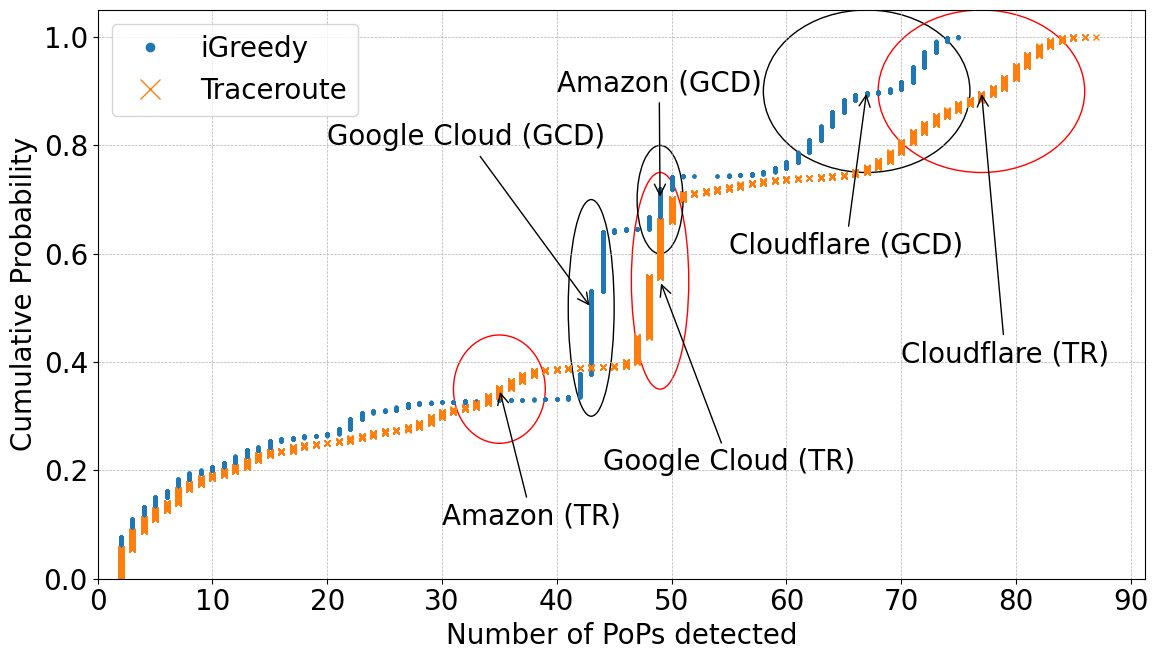


Descriptive Statistics for iGreedy:
count    13765.000000
mean        38.650999
std         22.739557
min          2.000000
25%         15.000000
50%         43.000000
75%         58.000000
max         75.000000
dtype: float64

Descriptive Statistics for traceroute:
count    13478.000000
mean        42.829797
std         25.399726
min          2.000000
25%         20.000000
50%         48.000000
75%         66.000000
max         87.000000
dtype: float64


In [402]:
igreedy_values = census['iGreedyICMPv4'].values
igreedy_values_sorted = np.sort(igreedy_values)
# Calculate CDF y-values
n_igreedy = len(igreedy_values_sorted)
y_cdf_igreedy = np.arange(1, n_igreedy + 1) / n_igreedy
print(f"Prepared {n_igreedy} iGreedyICMPv4 values (>1).")

city_counts_filtered = city_counts_per_dst[city_counts_per_dst > 1]

# Extract, sort enumeration values
city_count_values = city_counts_filtered.values
city_counts_sorted = np.sort(city_count_values)
# Calculate CDF values
n_city = len(city_counts_sorted)
y_cdf_city = np.arange(1, n_city + 1) / n_city
print(f"Prepared {n_city} city count values for {len(city_counts_per_dst)} destinations.")

print("\nPlotting combined CDFs...")

plt.figure(figsize=(12, 7))
# Plot GCD CDF
plt.plot(igreedy_values_sorted, y_cdf_igreedy,
         marker='.', linestyle='none', label='iGreedy', markersize=4)
# Plot TR CDF
plt.plot(city_counts_sorted, y_cdf_city,
         marker='x', linestyle='none', label='Traceroute', markersize=5)

plt.xlabel('Number of PoPs')
plt.ylabel('Cumulative Probability')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(0, 1.05)

all_x_values = np.concatenate((igreedy_values_sorted, city_counts_sorted))

max_x = np.max(all_x_values)
min_x_positive = all_x_values[all_x_values > 0].min() if np.any(all_x_values > 0) else 1

plt.rcParams.update({'font.size': 20})

plt.xlabel('Number of PoPs detected')
plt.xlim(left=0)
plt.xticks(np.arange(0, 90 + 1, 10))

plt.legend(markerscale=3)
plt.tight_layout()

plt.grid(True)

ellipse = patches.Ellipse((49, 0.55), width=5, height=0.4, # TR Google Cloud
                          angle=0, color='red', fill=False)
plt.gca().add_patch(ellipse)

ellipse = patches.Ellipse((35, 0.35), width=8, height=0.2, # TR Amazon
                          angle=0, color='red', fill=False)
plt.gca().add_patch(ellipse)

ellipse = patches.Ellipse((49, 0.7), width=4, height=0.2, # GCD Amazon
                          angle=0, color='black', fill=False)
plt.gca().add_patch(ellipse)

ellipse = patches.Ellipse((43, 0.5), width=4, height=0.4, # GCD Google
                          angle=0, color='black', fill=False)
plt.gca().add_patch(ellipse)

ellipse = patches.Ellipse((67, 0.9), width=18, height=0.3, # GCD Cloudflare
                          angle=0, color='black', fill=False)
plt.gca().add_patch(ellipse)

ellipse = patches.Ellipse((77, 0.9), width=18, height=0.3, # TR Cloudflare
                          angle=0, color='red', fill=False)
plt.gca().add_patch(ellipse)

plt.annotate('Google Cloud (GCD)', xy=(43, 0.5), xytext=(20, 0.8),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.annotate('Amazon (GCD)', xy=(49, 0.7), xytext=(40, 0.9),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.annotate('Google Cloud (TR)', xy=(49, 0.55), xytext=(44, 0.2),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.annotate('Amazon (TR)', xy=(35, 0.35), xytext=(30, 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.annotate('Cloudflare (TR)', xy=(77, 0.9), xytext=(70, 0.4),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.annotate('Cloudflare (GCD)', xy=(67, 0.9), xytext=(55, 0.6),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.savefig("enumeration_annotated.pdf", bbox_inches='tight', pad_inches=0)


plt.show()

print("\nDescriptive Statistics for iGreedy:")
print(pd.Series(igreedy_values_sorted).describe())

print("\nDescriptive Statistics for traceroute:")
print(pd.Series(city_counts_sorted).describe())

# run analysis w/o latency neighbor constraints toward root letters

In [289]:
# get results for root-letters, without using latency neighbors

roots = [
'198.41.0.4',
'170.247.170.2',
'192.33.4.12',
'199.7.91.13',
'192.203.230.10',
'192.5.5.0',
#'192.112.36.4', # g-root unresponsive to ICMP
'198.97.190.53',
'192.36.148.17',
'192.58.128.30',
'193.0.14.129',
'199.7.83.42',
'202.12.27.33']

In [290]:
traceroutes_roots = traceroutes_df[traceroutes_df['dst'].isin(roots)]
traceroutes_roots

,tx_hostname,dst,hop_count,probe_count,hop_addr,hop_probe_ttl,hop_rtt,hop_reply_ttl,ip4_address,hop_name,...,tx_airport,ark_to_hop,ark_to_pop,hop_asn,hop_city,hop_lat,hop_lon,is_neighbor,next_ttl,next_rtt
1485113,abz2-uk,170.247.170.2,16,17,137.50.19.1,1,0.301,255,137.50.19.1,milliways2-sbx-one-ipv4.erg.abdn.ac.uk,...,abz,30.755757,2131.649865,786,Aberdeen,57.143688,-2.09814,False,2.0,0.516
1485114,abz2-uk,170.247.170.2,16,17,137.50.0.33,2,0.516,253,137.50.0.33,ew-erg.wireless.abdn.ac.uk,...,abz,52.724155,2131.649865,786,Aberdeen,57.143688,-2.09814,False,3.0,0.504
1485115,abz2-uk,170.247.170.2,16,17,137.50.255.225,3,0.504,252,137.50.255.225,ewgw-core-to-mbgw-core-byod.abdn.ac.uk,...,abz,51.498012,2131.649865,786,Aberdeen,57.143688,-2.09814,False,4.0,0.403
1485116,abz2-uk,170.247.170.2,16,17,137.50.255.150,4,0.403,252,137.50.255.150,ewbyodfw3-to-ewgw-core.wireless.abdn.ac.uk,...,abz,41.177974,2131.649865,786,Aberdeen,57.143688,-2.09814,False,5.0,6.314
1485117,abz2-uk,170.247.170.2,16,17,146.97.128.9,5,6.314,251,146.97.128.9,xe-0-1-0.aberew-ban1.ja.net,...,abz,645.155654,2131.649865,786,London,51.508530,-0.12574,False,6.0,3.998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11690042,zrh4-ch,199.7.91.13,8,10,10.1.11.133,2,0.701,254,NaN,NaN,...,zrh,71.627196,68.153123,559,<NA>,NaN,NaN,True,3.0,0.428
11690043,zrh4-ch,199.7.91.13,8,10,10.1.11.129,3,0.428,253,NaN,NaN,...,zrh,43.732439,68.153123,559,<NA>,NaN,NaN,True,4.0,0.430
11690044,zrh4-ch,199.7.91.13,8,10,192.33.92.170,4,0.430,252,192.33.92.170,192-33-92-170.net4.ethz.ch,...,zrh,43.936796,68.153123,559,Zürich,47.366669,8.55000,True,5.0,3.470
11690045,zrh4-ch,199.7.91.13,8,10,192.33.92.11,5,3.470,251,192.33.92.11,swiez3.ethz.ch,...,zrh,354.559727,68.153123,559,Zürich,47.366669,8.55000,True,8.0,0.667


In [291]:
traceroute_roots_phops = traceroutes_roots[traceroutes_roots['dst'] != traceroutes_roots['hop_addr']].sort_values(by='hop_probe_ttl', ascending=False)\
                    .drop_duplicates(subset=['tx_hostname', 'dst'], keep='first')
traceroute_roots_phops = traceroute_roots_phops[~traceroute_roots_phops['hop_city'].isna()] # remove NaN phops (bogons)
traceroute_roots_phops

,tx_hostname,dst,hop_count,probe_count,hop_addr,hop_probe_ttl,hop_rtt,hop_reply_ttl,ip4_address,hop_name,...,tx_airport,ark_to_hop,ark_to_pop,hop_asn,hop_city,hop_lat,hop_lon,is_neighbor,next_ttl,next_rtt
812326,hnl4-us,192.58.128.30,25,30,178.172.80.1,24,222.748,227,NaN,NaN,...,hnl,22760.077851,22724.315343,2107,Ljubljana,46.051079,14.505130,True,25.0,222.398
19314852,puw-us,170.247.170.2,24,26,62.115.139.35,22,111.478,232,62.115.139.35,rest-bb1-link.ip.twelve99.net,...,puw,11390.665500,9032.894402,1299,Washington,38.895111,-77.036369,False,24.0,88.403
17926032,gye-ec,192.58.128.30,23,28,178.172.80.1,22,201.306,251,NaN,NaN,...,gye,20569.164401,20562.931506,2107,Ljubljana,46.051079,14.505130,True,23.0,201.245
12194477,ens-nl,192.58.128.30,22,23,140.189.8.9,21,125.316,238,140.189.8.9,r-chippewatc-hub-2-ae3.ip4.wiscnet.net,...,ens,12804.612908,12199.511264,2381,Plum City,44.629131,-92.192398,False,22.0,119.394
3065314,cjj-kr,170.247.170.2,22,24,190.103.186.241,21,225.976,53,190.103.186.241,f1-mia.b.isi.edu,...,cjj,23089.910359,19190.162072,20080,Miami,25.774269,-80.193657,False,22.0,187.810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20665560,dmk2-th,192.58.128.30,2,2,203.159.70.1,1,0.142,255,203.159.70.1,pub.r0.bknix.co.th,...,dmk,14.509361,12.772324,63528,<NA>,NaN,NaN,True,2.0,0.125
20089856,sql-us,170.247.170.2,4,6,192.158.252.3,1,0.222,255,192.158.252.3,r2.pao2-guests.isc.org,...,sql,22.683648,5775.747305,1280,Palo Alto,37.441879,-122.143021,False,4.0,56.526
18800163,dac-bd,192.58.128.30,2,2,202.59.208.1,1,0.057,64,NaN,NaN,...,dac,5.824180,10.933110,9825,Dhaka,23.710400,90.407440,True,2.0,0.107
15370,dar-tz,192.58.128.30,2,2,196.49.5.65,1,0.395,255,NaN,NaN,...,dar,40.360545,37.908259,327844,Dar es Salaam,-6.823490,39.269508,True,2.0,0.371


In [ ]:
# get inferred locations radian coordinates
traceroute_roots_phops['hop_lat'] = pd.to_numeric(traceroute_roots_phops['hop_lat'], errors='coerce')
traceroute_roots_phops['hop_lon'] = pd.to_numeric(traceroute_roots_phops['hop_lon'], errors='coerce')

traceroute_roots_phops['hop_lat_rad'] = np.radians(traceroute_roots_phops['hop_lat'])
traceroute_roots_phops['hop_lon_rad'] = np.radians(traceroute_roots_phops['hop_lon'])
inferred_coords_rad_roots = traceroute_roots_phops[['hop_lat_rad', 'hop_lon_rad']].values

In [310]:
np.isnan(inferred_coords_rad_roots).any(axis=1)

array([False, False, False, ..., False, False, False])

In [311]:
# create ball tree
print("\n--- Building BallTree ---")
tree = BallTree(airport_coords_rad, metric='haversine')

print("\n--- Querying nearby airports using BallTree ---")
start_time = time.time()
# Find indices AND distances of airports within the radius
# query_radius returns a list of arrays (one per query point)
# Each inner array contains indices of neighbors within the radius
nearby_indices_list, nearby_distances_list_rad = tree.query_radius(
    inferred_coords_rad_roots, r=DISK_DISTANCE_RAD, return_distance=True
)
# Convert distances from radians back to KM
nearby_distances_list_km = [dist_rad * EARTH_RADIUS_KM for dist_rad in nearby_distances_list_rad]
print(f"BallTree query_radius took {time.time() - start_time:.2f}s")


# fallback airport (closest airport)
print("\n--- Finding the absolute closest airport (fallback) ---")
start_time = time.time()
# query returns distances (in radians) and indices for the k=1 nearest neighbor
closest_dist_rad, closest_idx = tree.query(inferred_coords_rad_roots, k=1)
# closest_dist_km = closest_dist_rad[:, 0] * EARTH_RADIUS_KM # Distances in km
closest_indices = closest_idx[:, 0]  # Get the index array
print(f"BallTree query (k=1) took {time.time() - start_time:.2f}s")


--- Building BallTree ---

--- Querying nearby airports using BallTree ---
BallTree query_radius took 1.88s

--- Finding the absolute closest airport (fallback) ---
BallTree query (k=1) took 0.03s


In [312]:
# get inferred locations

results = []
print("\n--- Calculating heuristic for nearby airports ---")
start_time = time.time()

for i in range(len(inferred_coords_rad_roots)): # iterate through all final latency neighbors
    # retrieve the airports within the radius, and their distance from the latency neighbor
    nearby_indices = nearby_indices_list[i]
    nearby_distances_km = nearby_distances_list_km[i]

    # retrieve fallback airport for this point
    fallback_idx = closest_indices[i]
    fallback_airport_details = {
        'lat': airport_lat[fallback_idx],
        'lon': airport_lon[fallback_idx],
        'name': airport_name[fallback_idx],
        'iata': airport_iata[fallback_idx]
    }

    # heuristic calculation
    best_p = -1.0
    best_idx_in_disk = -1 # -1 -> no suitable airport found with heuristic

    if len(nearby_indices) > 0:
        # Filter again based on exact distance (though query_radius should be accurate)
        # This ensures we strictly adhere to DISK_DISTANCE_KM
        within_disk_mask = nearby_distances_km < DISK_DISTANCE_KM
        candidate_indices = nearby_indices[within_disk_mask]

        if len(candidate_indices) > 0:
            candidate_distances = nearby_distances_km[within_disk_mask]
            candidate_heuristics = airport_heuristics[candidate_indices]

            # Calculate totals for the denominator using ONLY candidates within the disk
            total_heuristic = np.sum(candidate_heuristics)
            # Sum of (Disk Distance - Actual Distance) for candidates
            total_inverse_distance_weighted = np.sum(DISK_DISTANCE_KM - candidate_distances)

            # Check denominators are valid AND non-zero
            if total_heuristic > 0 and total_inverse_distance_weighted > 1e-9: # Use small epsilon for float comparison
                # Calculate probability p for each candidate
                p_heuristic = ALPHA * (candidate_heuristics / total_heuristic)
                p_distance = (1 - ALPHA) * ((DISK_DISTANCE_KM - candidate_distances) / total_inverse_distance_weighted)
                p = p_heuristic + p_distance

                # Find the index *among candidates* with the highest p
                best_candidate_local_idx = np.argmax(p)
                # Map back to the original airport_df index
                best_idx_in_disk = candidate_indices[best_candidate_local_idx]

    if best_idx_in_disk != -1:
        # return best airport based on heuristic
        results.append({
            'lat': airport_lat[best_idx_in_disk],
            'lon': airport_lon[best_idx_in_disk],
            'name': airport_name[best_idx_in_disk],
            'iata': airport_iata[best_idx_in_disk]
        })
    else:
        # no airport in disk, use the closest airport
        results.append(fallback_airport_details)


print(f"Heuristic calculation loop took {time.time() - start_time:.2f}s")

print("\n--- Assembling final results ---")
# join results with inferred_df
final_roots = traceroute_roots_phops.join(pd.DataFrame(results, index=traceroute_roots_phops.index))
final_roots.rename(columns={'lat': 'inferred_airport_lat',
                         'lon': 'inferred_airport_lon',
                         'name': 'inferred_airport_name',
                         'iata': 'inferred_airport_iata'}, inplace=True)
final_roots


--- Calculating heuristic for nearby airports ---
Heuristic calculation loop took 0.09s

--- Assembling final results ---


,tx_hostname,dst,hop_count,probe_count,hop_addr,hop_probe_ttl,hop_rtt,hop_reply_ttl,ip4_address,hop_name,...,hop_lon,is_neighbor,next_ttl,next_rtt,hop_lat_rad,hop_lon_rad,inferred_airport_lat,inferred_airport_lon,inferred_airport_name,inferred_airport_iata
812326,hnl4-us,192.58.128.30,25,30,178.172.80.1,24,222.748,227,NaN,NaN,...,14.505130,True,25.0,222.398,0.803743,0.253162,46.223701,14.457600,Ljubljana Jože Pučnik Airport,LJU
19314852,puw-us,170.247.170.2,24,26,62.115.139.35,22,111.478,232,62.115.139.35,rest-bb1-link.ip.twelve99.net,...,-77.036369,False,24.0,88.403,0.678848,-1.344538,39.175400,-76.668297,Baltimore/Washington International Thurgood Marshall Airport,BWI
17926032,gye-ec,192.58.128.30,23,28,178.172.80.1,22,201.306,251,NaN,NaN,...,14.505130,True,23.0,201.245,0.803743,0.253162,46.223701,14.457600,Ljubljana Jože Pučnik Airport,LJU
12194477,ens-nl,192.58.128.30,22,23,140.189.8.9,21,125.316,238,140.189.8.9,r-chippewatc-hub-2-ae3.ip4.wiscnet.net,...,-92.192398,False,22.0,119.394,0.778925,-1.609061,44.882000,-93.221802,Minneapolis-St Paul International/Wold-Chamberlain Airport,MSP
3065314,cjj-kr,170.247.170.2,22,24,190.103.186.241,21,225.976,53,190.103.186.241,f1-mia.b.isi.edu,...,-80.193657,False,22.0,187.810,0.449846,-1.399643,25.793200,-80.290604,Miami,NAP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5780058,prg-cz,193.0.14.129,2,2,217.31.202.253,1,1.036,255,NaN,NaN,...,14.420760,True,2.0,0.529,0.874201,0.251690,50.100800,14.260000,Ruzyně International Airport,PRG
25882031,nrt-jp,198.97.190.53,4,6,203.181.248.65,1,0.333,255,203.181.248.65,tyo-mx10k-ae0-v64-caida.jp.apan.net,...,139.691711,True,4.0,0.548,0.622899,2.438080,35.552299,139.779999,Tokyo International Airport,JPP
20089856,sql-us,170.247.170.2,4,6,192.158.252.3,1,0.222,255,192.158.252.3,r2.pao2-guests.isc.org,...,-122.143021,False,4.0,56.526,0.653484,-2.131798,37.362598,-121.929001,Norman Y. Mineta San Jose International Airport,SJC
18800163,dac-bd,192.58.128.30,2,2,202.59.208.1,1,0.057,64,NaN,NaN,...,90.407440,True,2.0,0.107,0.413825,1.577907,23.843347,90.397783,Dhaka / Hazrat Shahjalal International Airport,DAC


In [314]:
final_roots.groupby('dst')['inferred_airport_iata'].nunique() # number of sites found per root-letter (without latency constraints)

dst
170.247.170.2     13
192.203.230.10    95
192.33.4.12       13
192.36.148.17     47
192.5.5.0         82
192.58.128.30     63
193.0.14.129      51
198.41.0.4        17
198.97.190.53     30
199.7.83.42       52
199.7.91.13       75
202.12.27.33      17
Name: inferred_airport_iata, dtype: int64

In [324]:
# get average enumeration increase

count_differences = []

print("--- Calculating Counts per Destination ---")

# --- Loop and Calculate ---
for letter in roots:
    # Calculate p-hop count for the current dst
    p_hop_count = final_roots[final_roots['dst'] == letter]['inferred_airport_iata'].nunique()

    # Calculate latency neighbor count for the current dst
    latency_count = final_df[final_df['dst'] == letter]['inferred_airport_iata'].nunique()

    # Calculate the difference (increase = p-hop - latency)
    difference = p_hop_count - latency_count
    count_differences.append(difference)



print("\n--- Average Calculation ---")
average_increase = sum(count_differences) / len(count_differences)

print(f"Total number of destinations processed: {len(count_differences)}")
print(f"Average increase (p-hop unique airports - latency unique airports): {average_increase:.4f}")


--- Calculating Counts per Destination ---

--- Average Calculation ---
Total number of destinations processed: 12
Average increase (p-hop unique airports - latency unique airports): 11.9167


In [323]:
# compare number of sites found for both TR techniques, per root-letter
for letter in roots:
    print(letter)
    print("p-hop count")
    print(final_roots[final_roots['dst'] == letter]['inferred_airport_iata'].nunique())
    print("latency neighbor count")
    print(final_df[final_df['dst'] == letter]['inferred_airport_iata'].nunique())
    print('\n')


198.41.0.4
p-hop count
17
latency neighbor count
15


170.247.170.2
p-hop count
13
latency neighbor count
7


192.33.4.12
p-hop count
13
latency neighbor count
9


199.7.91.13
p-hop count
75
latency neighbor count
69


192.203.230.10
p-hop count
95
latency neighbor count
85


192.5.5.0
p-hop count
82
latency neighbor count
75


198.97.190.53
p-hop count
30
latency neighbor count
13


192.36.148.17
p-hop count
47
latency neighbor count
31


192.58.128.30
p-hop count
63
latency neighbor count
41


193.0.14.129
p-hop count
51
latency neighbor count
23


199.7.83.42
p-hop count
52
latency neighbor count
32


202.12.27.33
p-hop count
17
latency neighbor count
12




In [315]:
final_roots.to_csv('/data/output/roots_no_latency_constraints.csv', index=False)

# run analysis with all phops

In [241]:
# get p-hops

p_hops = traceroutes_df[traceroutes_df['dst'] != traceroutes_df['hop_addr']].sort_values(by='hop_probe_ttl', ascending=False)\
                    .drop_duplicates(subset=['tx_hostname', 'dst'], keep='first')
# get the highest TTL hop that is not the destination for all VP, PoP pairs

p_hops

,tx_hostname,dst,hop_count,probe_count,hop_addr,hop_probe_ttl,hop_rtt,hop_reply_ttl,ip4_address,hop_name,...,tx_airport,ark_to_hop,ark_to_pop,hop_asn,hop_city,hop_lat,hop_lon,is_neighbor,next_ttl,next_rtt
3886303,hkg5-cn,23.11.40.7,44,56,23.40.189.1,43,453.065,28,23.40.189.1,vlan100.r01.tor01.hkg01.fab.netarch.akamai.com,...,hkg,46293.545494,23581.082868,20940,Hong Kong,22.320304,114.198074,False,44.0,230.783
19208202,puw-us,23.11.40.7,47,60,23.203.145.249,43,289.470,219,23.203.145.249,ae34.r03.border101.sea01.fab.netarch.akamai.com,...,puw,29577.638119,15443.170787,20940,Seattle,47.449001,-122.308998,False,47.0,151.139
16388104,bed-us,23.11.38.17,39,52,23.198.9.65,38,340.269,31,23.198.9.65,vlan100.r05.tor01.bos01.fab.netarch.akamai.com,...,bed,34768.208605,17588.103869,20940,Boston,42.364300,-71.005203,False,39.0,172.131
2510835,ind-us,23.11.38.17,38,49,154.24.97.54,37,462.866,223,NaN,NaN,...,ind,47294.997911,23495.150669,174,Indianapolis,39.768379,-86.158043,False,38.0,229.942
19661446,cpv-br,23.11.38.17,40,52,23.32.63.57,37,590.487,225,23.32.63.57,ae4.r01.gru01.icn.netarch.akamai.com,...,cpv,60335.132483,33415.568354,20940,Sao Paulo,-23.435556,-46.473057,False,40.0,327.031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5832009,prg-cz,94.152.255.1,4,6,217.31.202.253,1,0.887,255,NaN,NaN,...,prg,90.632414,846.038773,25192,Prague,50.088039,14.420760,False,4.0,8.280
5824516,prg-cz,67.14.160.0,4,6,217.31.202.253,1,0.681,255,NaN,NaN,...,prg,69.583624,838.068843,25192,Prague,50.088039,14.420760,False,4.0,8.202
5824518,prg-cz,67.14.161.0,4,6,217.31.202.253,1,0.617,255,NaN,NaN,...,prg,63.044194,849.001952,25192,Prague,50.088039,14.420760,False,4.0,8.309
5824520,prg-cz,67.14.162.0,4,6,217.31.202.253,1,0.701,255,NaN,NaN,...,prg,71.627196,835.923092,25192,Prague,50.088039,14.420760,False,4.0,8.181


In [242]:
# find the nearest Airport for each inferred location

def merge_nearest_airport(inferred_locs_df, locs_df):
    """
    Finds the nearest airport from final_df for each hop in inferred_df
    and merges airport details and distance.
    """
    # --- Prepare Airport Data ---
    # Drop airports with missing coordinates and reset index to keep track
    locs_df['inferred_airport_lat'] = pd.to_numeric(locs_df['inferred_airport_lat'], errors='coerce')
    locs_df['inferred_airport_lon'] = pd.to_numeric(locs_df['inferred_airport_lon'], errors='coerce')


    airports_valid = locs_df.dropna(subset=['inferred_airport_lat', 'inferred_airport_lon']).copy()


    # Convert valid airport coordinates to radians for BallTree
    airports_valid['lat_rad'] = np.radians(airports_valid['inferred_airport_lat'])
    airports_valid['lon_rad'] = np.radians(airports_valid['inferred_airport_lon'])
    airport_coords_rad = airports_valid[['lat_rad', 'lon_rad']].values

    # --- Prepare Hop Data ---
    # Identify hops with valid coordinates
    valid_hop_mask = inferred_locs_df['hop_lat'].notna() & inferred_locs_df['hop_lon'].notna()
    valid_hops = inferred_locs_df.loc[valid_hop_mask].copy()

    # Convert valid hop coordinates to radians
    valid_hops['hop_lat'] = pd.to_numeric(valid_hops['hop_lat'], errors='coerce')
    valid_hops['hop_lon'] = pd.to_numeric(valid_hops['hop_lon'], errors='coerce')

    valid_hops['lat_rad'] = np.radians(valid_hops['hop_lat'])
    valid_hops['lon_rad'] = np.radians(valid_hops['hop_lon'])
    hop_coords_rad = valid_hops[['lat_rad', 'lon_rad']].values

    # --- Build BallTree and Query ---
    # Build tree on airport coordinates
    tree = BallTree(airport_coords_rad, metric='haversine')

    # Query the tree for the nearest airport (k=1) for each valid hop
    # Returns distances in radians and indices *relative to airport_coords_rad*
    distances_rad, indices_in_tree = tree.query(hop_coords_rad, k=1)

    # --- Process Results ---
    # Get the original indices from final_df corresponding to the nearest airports
    nearest_airport_original_indices = airports_valid.index[indices_in_tree.flatten()]

    # Calculate distances in kilometers
    distances_km = distances_rad.flatten() * EARTH_RADIUS_KM

    # Create a DataFrame with results, indexed by the original index of valid_hops
    results_df = pd.DataFrame({
        'nearest_airport_original_idx': nearest_airport_original_indices,
        'distance_to_nearest_airport_km': distances_km
    }, index=valid_hops.index) # Use the original index from inferred_df

    # --- Merge Results back to original inferred_df ---
    # Create the new columns in the original inferred_df, initially filled with NaN
    for col in ['nearest_airport_lat', 'nearest_airport_lon', 'nearest_airport_name',
                'nearest_airport_iata', 'distance_to_nearest_airport_km']:
        inferred_locs_df[col] = np.nan

    # Fill distance for valid hops
    inferred_locs_df.loc[results_df.index, 'distance_to_nearest_airport_km'] = results_df['distance_to_nearest_airport_km']

    # Use the nearest_airport_original_idx to look up details in the original final_df
    # Use .loc for safe assignment based on index alignment
    nearest_indices = results_df['nearest_airport_original_idx']
    inferred_locs_df.loc[results_df.index, 'nearest_airport_lat'] = locs_df.loc[nearest_indices, 'inferred_airport_lat'].values
    inferred_locs_df.loc[results_df.index, 'nearest_airport_lon'] = locs_df.loc[nearest_indices, 'inferred_airport_lon'].values
    inferred_locs_df.loc[results_df.index, 'nearest_airport_name'] = locs_df.loc[nearest_indices, 'inferred_airport_name'].values
    inferred_locs_df.loc[results_df.index, 'nearest_airport_iata'] = locs_df.loc[nearest_indices, 'inferred_airport_iata'].values


    return inferred_locs_df

# Example Usage (assuming inferred_df and final_df are already loaded)
combined_df = merge_nearest_airport(p_hops, final_df)
# combined_df = merge_nearest_airport(inferred_df, final_df)
combined_df

/var/folders/k_/b2zc8kg571bcqh2l9j8mj82h0000gn/T/ipykernel_46892/80819447.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Chek Lap Kok International Airport'
 'Boeing Field King County International Airport'
 'General Edward Lawrence Logan International Airport' ...
 'Ruzyně International Airport' 'Ruzyně International Airport'
 'Ruzyně International Airport']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inferred_locs_df.loc[results_df.index, 'nearest_airport_name'] = locs_df.loc[nearest_indices, 'inferred_airport_name'].values
/var/folders/k_/b2zc8kg571bcqh2l9j8mj82h0000gn/T/ipykernel_46892/80819447.py:91: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['HKG' 'BFI' 'BOS' ... 'PRG' 'PRG' 'PRG']' has dtype incompatible with float64, please explicitly cast to a compatible 

,tx_hostname,dst,hop_count,probe_count,hop_addr,hop_probe_ttl,hop_rtt,hop_reply_ttl,ip4_address,hop_name,...,hop_lat,hop_lon,is_neighbor,next_ttl,next_rtt,nearest_airport_lat,nearest_airport_lon,nearest_airport_name,nearest_airport_iata,distance_to_nearest_airport_km
3886303,hkg5-cn,23.11.40.7,44,56,23.40.189.1,43,453.065,28,23.40.189.1,vlan100.r01.tor01.hkg01.fab.netarch.akamai.com,...,22.320304,114.198074,False,44.0,230.783,22.308889,113.914722,Chek Lap Kok International Airport,HKG,29.175437
19208202,puw-us,23.11.40.7,47,60,23.203.145.249,43,289.470,219,23.203.145.249,ae34.r03.border101.sea01.fab.netarch.akamai.com,...,47.449001,-122.308998,False,47.0,151.139,47.529999,-122.302002,Boeing Field King County International Airport,BFI,9.021869
16388104,bed-us,23.11.38.17,39,52,23.198.9.65,38,340.269,31,23.198.9.65,vlan100.r05.tor01.bos01.fab.netarch.akamai.com,...,42.364300,-71.005203,False,39.0,172.131,42.364300,-71.005203,General Edward Lawrence Logan International Airport,BOS,0.000033
2510835,ind-us,23.11.38.17,38,49,154.24.97.54,37,462.866,223,NaN,NaN,...,39.768379,-86.158043,False,38.0,229.942,39.717300,-86.294403,Indianapolis International Airport,IND,12.968696
19661446,cpv-br,23.11.38.17,40,52,23.32.63.57,37,590.487,225,23.32.63.57,ae4.r01.gru01.icn.netarch.akamai.com,...,-23.435556,-46.473057,False,40.0,327.031,-23.509100,-46.637798,Campo de Marte Airport,SAO,18.686953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5832009,prg-cz,94.152.255.1,4,6,217.31.202.253,1,0.887,255,NaN,NaN,...,50.088039,14.420760,False,4.0,8.280,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130
5824516,prg-cz,67.14.160.0,4,6,217.31.202.253,1,0.681,255,NaN,NaN,...,50.088039,14.420760,False,4.0,8.202,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130
5824518,prg-cz,67.14.161.0,4,6,217.31.202.253,1,0.617,255,NaN,NaN,...,50.088039,14.420760,False,4.0,8.309,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130
5824520,prg-cz,67.14.162.0,4,6,217.31.202.253,1,0.701,255,NaN,NaN,...,50.088039,14.420760,False,4.0,8.181,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130


In [244]:
combined_df['distance_to_nearest_airport_km'].mean() # 20km mean for valid latency neighbors, 26k mean for p-hops

26.525414523019133

In [282]:
# bogon p-hops
combined_df[combined_df['hop_addr'].str.startswith('10.')]

,tx_hostname,dst,hop_count,probe_count,hop_addr,hop_probe_ttl,hop_rtt,hop_reply_ttl,ip4_address,hop_name,...,hop_lat,hop_lon,is_neighbor,next_ttl,next_rtt,nearest_airport_lat,nearest_airport_lon,nearest_airport_name,nearest_airport_iata,distance_to_nearest_airport_km
10797560,bkl-us,44.31.110.0,34,37,10.64.1.186,32,72.655,52,NaN,NaN,...,NaN,NaN,False,34.0,112.768,NaN,NaN,NaN,NaN,NaN
3994211,osl-no,193.19.225.2,33,44,10.79.1.174,31,266.681,49,NaN,NaN,...,NaN,NaN,False,33.0,272.906,NaN,NaN,NaN,NaN,NaN
343127,bdl-us,44.31.110.0,33,34,10.64.1.182,31,74.293,58,NaN,NaN,...,NaN,NaN,True,33.0,73.710,NaN,NaN,NaN,NaN,NaN
16824891,lun-zm,43.224.183.166,32,35,10.73.201.22,31,513.738,46,NaN,NaN,...,NaN,NaN,True,32.0,514.082,NaN,NaN,NaN,NaN,NaN
6021659,tlv3-il,46.8.8.66,31,41,10.79.1.118,30,281.252,51,NaN,NaN,...,NaN,NaN,True,31.0,280.850,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12954427,wlg2-nz,138.199.49.1,4,5,10.101.0.158,3,10.456,251,NaN,NaN,...,NaN,NaN,False,4.0,131.470,NaN,NaN,NaN,NaN,NaN
6401646,hyd-in,156.154.58.1,6,10,10.130.32.1,2,1.165,63,NaN,NaN,...,NaN,NaN,False,6.0,23.121,NaN,NaN,NaN,NaN,NaN
6407864,hyd-in,173.243.129.1,6,10,10.130.32.1,2,1.000,63,NaN,NaN,...,NaN,NaN,False,6.0,22.179,NaN,NaN,NaN,NaN,NaN
6355310,hyd-in,209.131.101.100,6,10,10.130.32.1,2,0.761,63,NaN,NaN,...,NaN,NaN,True,6.0,2.294,NaN,NaN,NaN,NaN,NaN


In [283]:
# how many are NOT within 3 ms of the target
combined_df[~combined_df['is_neighbor']]



,tx_hostname,dst,hop_count,probe_count,hop_addr,hop_probe_ttl,hop_rtt,hop_reply_ttl,ip4_address,hop_name,...,hop_lat,hop_lon,is_neighbor,next_ttl,next_rtt,nearest_airport_lat,nearest_airport_lon,nearest_airport_name,nearest_airport_iata,distance_to_nearest_airport_km
3886303,hkg5-cn,23.11.40.7,44,56,23.40.189.1,43,453.065,28,23.40.189.1,vlan100.r01.tor01.hkg01.fab.netarch.akamai.com,...,22.320304,114.198074,False,44.0,230.783,22.308889,113.914722,Chek Lap Kok International Airport,HKG,29.175437
19208202,puw-us,23.11.40.7,47,60,23.203.145.249,43,289.470,219,23.203.145.249,ae34.r03.border101.sea01.fab.netarch.akamai.com,...,47.449001,-122.308998,False,47.0,151.139,47.529999,-122.302002,Boeing Field King County International Airport,BFI,9.021869
16388104,bed-us,23.11.38.17,39,52,23.198.9.65,38,340.269,31,23.198.9.65,vlan100.r05.tor01.bos01.fab.netarch.akamai.com,...,42.364300,-71.005203,False,39.0,172.131,42.364300,-71.005203,General Edward Lawrence Logan International Airport,BOS,0.000033
2510835,ind-us,23.11.38.17,38,49,154.24.97.54,37,462.866,223,NaN,NaN,...,39.768379,-86.158043,False,38.0,229.942,39.717300,-86.294403,Indianapolis International Airport,IND,12.968696
19661446,cpv-br,23.11.38.17,40,52,23.32.63.57,37,590.487,225,23.32.63.57,ae4.r01.gru01.icn.netarch.akamai.com,...,-23.435556,-46.473057,False,40.0,327.031,-23.509100,-46.637798,Campo de Marte Airport,SAO,18.686953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5832009,prg-cz,94.152.255.1,4,6,217.31.202.253,1,0.887,255,NaN,NaN,...,50.088039,14.420760,False,4.0,8.280,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130
5824516,prg-cz,67.14.160.0,4,6,217.31.202.253,1,0.681,255,NaN,NaN,...,50.088039,14.420760,False,4.0,8.202,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130
5824518,prg-cz,67.14.161.0,4,6,217.31.202.253,1,0.617,255,NaN,NaN,...,50.088039,14.420760,False,4.0,8.309,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130
5824520,prg-cz,67.14.162.0,4,6,217.31.202.253,1,0.701,255,NaN,NaN,...,50.088039,14.420760,False,4.0,8.181,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130


In [284]:
# how many are within 3ms of the target
combined_df[combined_df['is_neighbor']]


,tx_hostname,dst,hop_count,probe_count,hop_addr,hop_probe_ttl,hop_rtt,hop_reply_ttl,ip4_address,hop_name,...,hop_lat,hop_lon,is_neighbor,next_ttl,next_rtt,nearest_airport_lat,nearest_airport_lon,nearest_airport_name,nearest_airport_iata,distance_to_nearest_airport_km
16381076,bed-us,203.24.54.4,37,43,203.34.30.181,36,259.226,232,203.34.30.181,xe-2-579-rt1.perma.zettagrid.com,...,-31.952240,115.861397,True,37.0,259.894,-31.940300,115.967003,Perth International Airport,PER,10.052402
14059800,mem-us,91.237.67.0,37,39,87.44.56.138,36,279.795,244,NaN,NaN,...,53.333061,-6.248890,True,37.0,279.738,53.421299,-6.270070,Dublin Airport,DUB,9.911669
16367629,bed-us,103.79.5.1,37,41,103.197.232.191,36,232.999,233,NaN,NaN,...,-33.867851,151.207321,True,37.0,234.500,-33.924400,150.988007,Sydney Bankstown Airport,BWU,21.196300
16381107,bed-us,203.30.19.12,37,43,203.34.30.181,36,259.773,232,203.34.30.181,xe-2-579-rt1.perma.zettagrid.com,...,-31.952240,115.861397,True,37.0,260.656,-31.940300,115.967003,Perth International Airport,PER,10.052402
16462709,bed-us,119.252.64.41,36,40,203.196.94.203,35,211.732,43,NaN,NaN,...,-33.867851,151.207321,True,36.0,212.387,-33.924400,150.988007,Sydney Bankstown Airport,BWU,21.196300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5780060,prg-cz,193.0.15.254,2,2,217.31.202.253,1,0.955,255,NaN,NaN,...,50.088039,14.420760,True,2.0,0.516,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130
5853542,prg-cz,185.38.108.108,2,2,217.31.202.253,1,1.102,255,NaN,NaN,...,50.088039,14.420760,True,2.0,0.363,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130
5854150,prg-cz,190.124.27.10,2,2,217.31.202.253,1,0.892,255,NaN,NaN,...,50.088039,14.420760,True,2.0,0.406,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130
5785032,prg-cz,200.7.4.1,2,2,217.31.202.253,1,0.674,255,NaN,NaN,...,50.088039,14.420760,True,2.0,0.354,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130


In [285]:
# how many are latency neighbor hops
combined_df[combined_df['is_neighbor'] & (combined_df['pop_rtt'] < TRACEROUTE_MAX_LATENCY)]

,tx_hostname,dst,hop_count,probe_count,hop_addr,hop_probe_ttl,hop_rtt,hop_reply_ttl,ip4_address,hop_name,...,hop_lat,hop_lon,is_neighbor,next_ttl,next_rtt,nearest_airport_lat,nearest_airport_lon,nearest_airport_name,nearest_airport_iata,distance_to_nearest_airport_km
24242602,agb-de,23.11.40.7,23,31,23.210.52.235,22,11.539,234,23.210.52.235,ae3.decix-fra.netarch.akamai.com,...,50.033333,8.570556,True,23.0,9.983,50.026402,8.543130,Frankfurt am Main International Airport,FRA,2.105217
27203320,oak5-us,66.174.0.3,22,29,63.59.164.212,21,9.621,233,NaN,NaN,...,37.339390,-121.894958,True,22.0,10.717,37.362598,-121.929001,Norman Y. Mineta San Jose International Airport,SJC,3.964158
2947846,cjj-kr,207.189.149.0,22,27,141.101.82.12,21,4.745,244,NaN,NaN,...,37.566002,126.978401,True,22.0,3.874,37.558300,126.791000,Gimpo International Airport,SEL,16.540326
11857756,fra-de,23.11.40.7,25,34,23.210.54.63,21,1.110,44,23.210.54.63,ae34.r03.border101.fra03.fab.netarch.akamai.com,...,50.033333,8.570556,True,25.0,0.873,50.026402,8.543130,Frankfurt am Main International Airport,FRA,2.105217
8383659,cdg4-fr,185.77.72.1,21,26,195.157.3.184,20,9.085,55,195.157.3.184,po2-hod-mse1.router.uk.clara.net,...,51.508530,-0.125740,True,21.0,8.981,51.148102,-0.190278,London Gatwick Airport,LGW,40.327823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5780060,prg-cz,193.0.15.254,2,2,217.31.202.253,1,0.955,255,NaN,NaN,...,50.088039,14.420760,True,2.0,0.516,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130
5853542,prg-cz,185.38.108.108,2,2,217.31.202.253,1,1.102,255,NaN,NaN,...,50.088039,14.420760,True,2.0,0.363,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130
5854150,prg-cz,190.124.27.10,2,2,217.31.202.253,1,0.892,255,NaN,NaN,...,50.088039,14.420760,True,2.0,0.406,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130
5785032,prg-cz,200.7.4.1,2,2,217.31.202.253,1,0.674,255,NaN,NaN,...,50.088039,14.420760,True,2.0,0.354,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130


In [286]:
# how many are invalid latency neighbors

invalids = combined_df[~combined_df['is_neighbor'] | (combined_df['pop_rtt'] > TRACEROUTE_MAX_LATENCY)]
invalids

,tx_hostname,dst,hop_count,probe_count,hop_addr,hop_probe_ttl,hop_rtt,hop_reply_ttl,ip4_address,hop_name,...,hop_lat,hop_lon,is_neighbor,next_ttl,next_rtt,nearest_airport_lat,nearest_airport_lon,nearest_airport_name,nearest_airport_iata,distance_to_nearest_airport_km
3886303,hkg5-cn,23.11.40.7,44,56,23.40.189.1,43,453.065,28,23.40.189.1,vlan100.r01.tor01.hkg01.fab.netarch.akamai.com,...,22.320304,114.198074,False,44.0,230.783,22.308889,113.914722,Chek Lap Kok International Airport,HKG,29.175437
19208202,puw-us,23.11.40.7,47,60,23.203.145.249,43,289.470,219,23.203.145.249,ae34.r03.border101.sea01.fab.netarch.akamai.com,...,47.449001,-122.308998,False,47.0,151.139,47.529999,-122.302002,Boeing Field King County International Airport,BFI,9.021869
16388104,bed-us,23.11.38.17,39,52,23.198.9.65,38,340.269,31,23.198.9.65,vlan100.r05.tor01.bos01.fab.netarch.akamai.com,...,42.364300,-71.005203,False,39.0,172.131,42.364300,-71.005203,General Edward Lawrence Logan International Airport,BOS,0.000033
2510835,ind-us,23.11.38.17,38,49,154.24.97.54,37,462.866,223,NaN,NaN,...,39.768379,-86.158043,False,38.0,229.942,39.717300,-86.294403,Indianapolis International Airport,IND,12.968696
19661446,cpv-br,23.11.38.17,40,52,23.32.63.57,37,590.487,225,23.32.63.57,ae4.r01.gru01.icn.netarch.akamai.com,...,-23.435556,-46.473057,False,40.0,327.031,-23.509100,-46.637798,Campo de Marte Airport,SAO,18.686953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5832009,prg-cz,94.152.255.1,4,6,217.31.202.253,1,0.887,255,NaN,NaN,...,50.088039,14.420760,False,4.0,8.280,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130
5824516,prg-cz,67.14.160.0,4,6,217.31.202.253,1,0.681,255,NaN,NaN,...,50.088039,14.420760,False,4.0,8.202,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130
5824518,prg-cz,67.14.161.0,4,6,217.31.202.253,1,0.617,255,NaN,NaN,...,50.088039,14.420760,False,4.0,8.309,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130
5824520,prg-cz,67.14.162.0,4,6,217.31.202.253,1,0.701,255,NaN,NaN,...,50.088039,14.420760,False,4.0,8.181,50.100800,14.260000,Ruzyně International Airport,PRG,11.555130


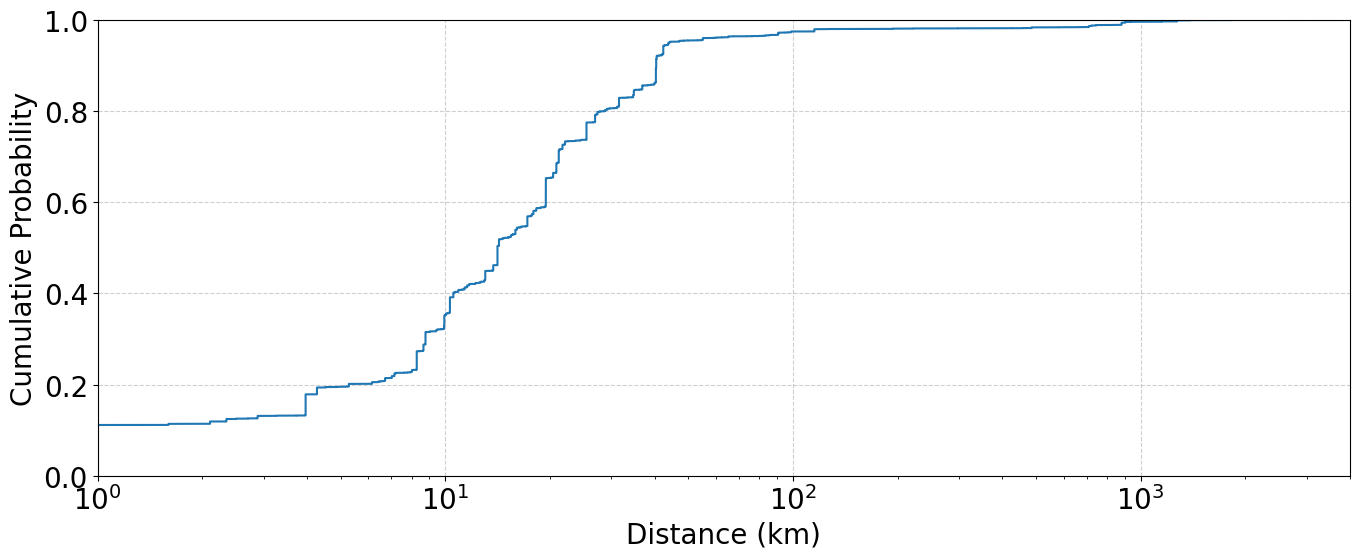

In [336]:
# plot for invalids

rtt_data = invalids['pop_rtt'].dropna()
distance_data = invalids['distance_to_nearest_airport_km'].dropna()

def calculate_cdf(series):
    """Calculates sorted data and cumulative probabilities for a CDF."""
    data_sorted = np.sort(series)
    n = data_sorted.size
    y_cdf = np.arange(1, n + 1) / n
    return data_sorted, y_cdf

fig, axes = plt.subplots(figsize=(14, 6))

x_dist, y_dist_cdf = calculate_cdf(distance_data)
ax = axes
ax.plot(x_dist, y_dist_cdf, drawstyle='steps-post', linestyle='-')

ax.set_xlabel('Distance (km)')
ax.set_ylabel('Cumulative Probability')
ax.grid(True, linestyle='--', alpha=0.6)

ax.set_ylim(0, 1)
ax.set_xlim(1, 4_000)
ax.set_xscale('log')

plt.tight_layout()

plt.savefig("phop_distances_log.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

# Anycast upstream ASes [future work]

In [385]:
# get AS relationship from CAIDA
file_path = './data/relationships/serial-1/20250301.as-rel.txt.bz2'
column_names = ['col1_asn', 'col2_asn', 'relationship_code']

print(f"Attempting to load {file_path}...")

try:
    # Use pandas read_csv with appropriate options
    as_rel_df = pd.read_csv(
        file_path,
        compression='bz2',
        sep='|',
        comment='#',
        header=None,
        names=column_names,
        dtype={
            'col1_asn': 'int32',
            'col2_asn': 'int32',
            'relationship_code': 'int8'
        }
    )

    print("File loaded successfully!")

except FileNotFoundError:
    print(f"Error: File not found at '{file_path}'. Please check the path.")
except pd.errors.EmptyDataError:
     print(f"Error: The file '{file_path}' is empty or contains only comments.")
except ValueError as ve:
    print(f"Error converting data types: {ve}")
    print("Please check if the file format strictly follows <integer>|<integer>|<integer> after comments.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# annotate relationship types
relationship_map = {-1: 'p2c', 0: 'p2p'}
as_rel_df['relationship'] = as_rel_df['relationship_code'].map(relationship_map)

as_rel_df

Attempting to load relationships/serial-1/20250301.as-rel.txt.bz2...
File loaded successfully!


,col1_asn,col2_asn,relationship_code,relationship
0,174,209,0,p2p
1,174,286,0,p2p
2,174,701,0,p2p
3,174,1239,0,p2p
4,174,1299,0,p2p
...,...,...,...,...
490247,41289,59605,0,p2p
490248,12676,59605,0,p2p
490249,6876,59605,0,p2p
490250,20847,59605,0,p2p


In [390]:
# TODO broken

## obtain upstream ASN
merged_df_prev = pd.merge(inferred_df, final_df, on=['tx_hostname', 'dst'], how='left')
merged_df_prev['hop_asn_str'] = merged_df_prev['hop_asn'].astype(str)
merged_df_prev['anycast_asn_str'] = merged_df_prev['anycast_asn'].astype(str)
# remove NaN and ASNs that are the anycast ASN
filtered_hops_prev = merged_df_prev[
    pd.notna(merged_df_prev['hop_asn']) &
    (merged_df_prev['hop_asn_str'] != merged_df_prev['anycast_asn_str'])
]

# get the ASN preceding the anycast ASN (using the hop with the highest TTL value)
if not filtered_hops_prev.empty:
    idx_prev = filtered_hops_prev.loc[filtered_hops_prev.groupby(
        ['tx_hostname', 'dst'], observed=True, dropna=False
        )['hop_probe_ttl'].idxmax()]
    closest_asn_df_prev = idx_prev[['tx_hostname', 'dst', 'hop_asn']].rename(
        columns={'hop_asn': 'inferred_upstream'}
    )
    result_df = pd.merge(inferred_df, closest_asn_df_prev, on=['tx_hostname', 'dst'], how='left')
else:
    result_df = inferred_df
    result_df['inferred_upstream'] = pd.NA

## obtain full path
path_data_df = pd.merge(
    final_df[['tx_hostname', 'dst', 'hop_asn', 'hop_probe_ttl']],
    inferred_df[['tx_hostname', 'dst', 'anycast_asn']],
    on=['tx_hostname', 'dst'],
    how='inner'
)
path_data_df['hop_probe_ttl'] = pd.to_numeric(path_data_df['hop_probe_ttl'], errors='coerce')
path_data_df = path_data_df.dropna(subset=['hop_probe_ttl'])

def create_asn_path(group):
    """
    Create the ASNs traversed by a traceroute
    """
    # order by TTL (path starts with lowest TTL)
    sorted_group = group.sort_values('hop_probe_ttl')

    # get list of hop_asn values (NaN / unknown ASNs have value 0)
    cleaned_asns = sorted_group['hop_asn'].fillna('0').astype(str).str.replace('-', '0', regex=False).tolist()

    anycast_asn_val = group['anycast_asn'].iloc[0]
    anycast_asn_str = str(int(anycast_asn_val)) if pd.notna(anycast_asn_val) else '0'

    # add anycast_asn to end of path
    full_sequence = cleaned_asns + [anycast_asn_str]

    # remove consecutive repeated ASN duplicate values (789_13335_13335_13335 -> 789_13335)
    deduplicated_sequence = [full_sequence[0]]
    for i in range(1, len(full_sequence)):
        if full_sequence[i] != deduplicated_sequence[-1]:
            deduplicated_sequence.append(full_sequence[i])

    return '_'.join(deduplicated_sequence)

# add the path as a new column
full_path_series = path_data_df.groupby(
    ['tx_hostname', 'dst'],
    observed=True,
    dropna=False
).apply(create_asn_path)

full_path_df = full_path_series.to_frame(name='full_path').reset_index()

# merge results
final_result_df = pd.merge(
    result_df,
    full_path_df,
    on=['tx_hostname', 'dst'],
    how='left'
)

final_result_df

ValueError: invalid literal for int() with base 10: '-'

In [230]:
# TODO for each inferred_upstream, check if the relationship is in the caida file

final_result_df.groupby(['anycast_asn', 'inferred_upstream']).to_frame().reset_index()#.unique()

AttributeError: 'DataFrameGroupBy' object has no attribute 'to_frame'

In [195]:
final_result_df[['tx_hostname', 'dst', 'inferred_city', 'inferred_upstream', 'full_path']]

,tx_hostname,dst,inferred_city,inferred_upstream,full_path
0,abz2-uk,1.1.1.1,Manchester,786,786_13335
1,abz2-uk,8.8.8.8,London,786,786_15169
2,acv-us,1.1.1.1,San Jose,2152,2153_2152_13335
3,acv-us,8.8.8.8,San Jose,2152,2153_2152_15169
4,adl-au,1.1.1.1,Adelaide,-,0_134090_0_13335
...,...,...,...,...,...
248,xna-us,8.8.8.8,Dallas,40581,0_10508_40581_15169
249,ygk-ca,1.1.1.1,Toronto,3257,31983_0_3257_13335
250,ygk-ca,8.8.8.8,Toronto,26677,31983_0_26677_15169
251,yto-ca,1.1.1.1,Toronto,-,0_13335


In [196]:
final_result_df[final_result_df['dst'] == '1.1.1.1']['inferred_upstream'].nunique()

37

In [197]:
final_result_df[final_result_df['dst'] == '8.8.8.8']['inferred_upstream'].nunique()


56

In [97]:
# TODO for each PoP, identify the upstreams traversed (and the ASN path)

# Investigate probing cost

In [ ]:
# infer hops adjacent to the VP with bogon addresses to be in the same ASN

df = traceroutes_df

# Define the value indicating a missing ASN
MISSING_ASN_VALUE = '-'
# Or if using NaN:
# MISSING_ASN_VALUE = np.nan

# Sort by traceroute identifier and then by hop TTL
df.sort_values(['tx_hostname', 'dst', 'hop_probe_ttl'], inplace=True)

# 2. Identify hops with valid ASNs
df['asn_is_valid'] = df['hop_asn'] != MISSING_ASN_VALUE



# 3. Identify the initial segment *before* the first valid ASN within each group
# Use groupby and cummax(). cummax() propagates the first 'True' value downwards.
# So, where cummax() is False, it means no valid ASN has been seen *yet* in that group.
df['seen_valid_asn'] = df.groupby(['tx_hostname', 'dst'])['asn_is_valid'].cummax()

# 4. Determine which rows need filling
# Rows to fill are those where:
#   a) The ASN is currently missing (hop_asn == MISSING_ASN_VALUE)
#   b) No valid ASN has been encountered *before* or *at* this hop in the sequence (seen_valid_asn == False)
rows_to_fill_mask = (df['hop_asn'] == MISSING_ASN_VALUE) & (~df['seen_valid_asn'])
# Or if using NaN for missing:
# rows_to_fill_mask = df['hop_asn'].isna() & (~df['seen_valid_asn'])


# 5. Apply the fill using the mask
# Use .loc to update 'hop_asn' only for the identified rows, setting it to 'vp_asn'
df.loc[rows_to_fill_mask, 'hop_asn'] = df.loc[rows_to_fill_mask, 'vp_asn']

# 6. Clean up temporary columns (optional)
df.drop(columns=['asn_is_valid', 'seen_valid_asn'], inplace=True)

In [167]:
# fill in hop ASNs (hops in-between two hops with the same AS are inferred to be in that same AS, if they have no AS data)

df['hop_asn_temp'] = df['hop_asn'].replace(MISSING_ASN_VALUE, np.nan)


# 1. Forward fill ASNs within each traceroute group
# This propagates the last valid ASN downwards.
df['asn_ffill'] = df.groupby(['tx_hostname', 'dst'])['hop_asn_temp'].ffill()

# 2. Backward fill ASNs within each traceroute group
# This propagates the next valid ASN upwards.
df['asn_bfill'] = df.groupby(['tx_hostname', 'dst'])['hop_asn_temp'].bfill()

# 3. Identify the rows to fill
# We fill a row if:
#   a) Its original ASN was missing (check the original 'hop_asn' column).
#   b) The forward-filled ASN is the same as the backward-filled ASN.
#   c) The filled value is not NaN (meaning both ffill and bfill found a valid ASN).

fill_condition = (
    (df['hop_asn'] == MISSING_ASN_VALUE) &  # Original was missing
    (df['asn_ffill'] == df['asn_bfill']) &  # Surrounding valid ASNs match
    (df['asn_ffill'].notna())              # The matching ASN is a valid number
)

# 4. Apply the fill
df.loc[fill_condition, 'hop_asn'] = df.loc[fill_condition, 'asn_ffill']

df.drop(columns=['hop_asn_temp', 'asn_ffill', 'asn_bfill'], inplace=True)

df

,tx_hostname,dst,hop_count,probe_count,hop_addr,hop_probe_ttl,hop_rtt,hop_reply_ttl,ip4_address,hop_name,...,tx_city,vp_asn,tx_airport,ark_to_hop,ark_to_pop,hop_asn,hop_city,hop_lat,hop_lon,is_neighbor
1324098,abz2-uk,1.0.0.0,11,11,137.50.19.1,1,0.318,255,137.50.19.1,milliways2-sbx-one-ipv4.erg.abdn.ac.uk,...,Aberdeen,786,abz,32.492793,1380.024115,786,Aberdeen,57.143688,-2.09814,False
1324537,abz2-uk,1.0.0.0,11,12,137.50.19.1,1,0.326,255,137.50.19.1,milliways2-sbx-one-ipv4.erg.abdn.ac.uk,...,Aberdeen,786,abz,33.310222,1380.024115,786,Aberdeen,57.143688,-2.09814,False
1325067,abz2-uk,1.0.0.0,11,11,137.50.19.1,1,0.348,255,137.50.19.1,milliways2-sbx-one-ipv4.erg.abdn.ac.uk,...,Aberdeen,786,abz,35.558151,1380.024115,786,Aberdeen,57.143688,-2.09814,False
1325895,abz2-uk,1.0.0.0,11,11,137.50.19.1,1,0.336,255,137.50.19.1,milliways2-sbx-one-ipv4.erg.abdn.ac.uk,...,Aberdeen,786,abz,34.332008,1380.024115,786,Aberdeen,57.143688,-2.09814,False
1327020,abz2-uk,1.0.0.0,11,11,137.50.19.1,1,0.314,255,137.50.19.1,milliways2-sbx-one-ipv4.erg.abdn.ac.uk,...,Aberdeen,786,abz,32.084079,1380.024115,786,Aberdeen,57.143688,-2.09814,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11729342,zrh4-ch,98.98.157.0,10,14,10.1.11.133,2,0.497,254,NaN,NaN,...,Zurich,559,zrh,50.782762,137.941104,559,<NA>,NaN,NaN,True
11729343,zrh4-ch,98.98.157.0,10,14,10.1.11.129,3,0.518,253,NaN,NaN,...,Zurich,559,zrh,52.928513,137.941104,559,<NA>,NaN,NaN,True
11729344,zrh4-ch,98.98.157.0,10,14,192.33.92.170,4,0.571,252,192.33.92.170,192-33-92-170.net4.ethz.ch,...,Zurich,559,zrh,58.343978,137.941104,559,Zürich,47.366669,8.55000,True
11729345,zrh4-ch,98.98.157.0,10,14,192.33.92.11,5,1.808,251,192.33.92.11,swiez3.ethz.ch,...,Zurich,559,zrh,184.738901,137.941104,559,Zürich,47.366669,8.55000,True


In [189]:
# what is the average hop count?

df.groupby(['tx_hostname', 'dst'])['hop_count'].first().mean()

9.828091099985004

In [191]:
# what is the average hop count (< 12 ms)

df[df['pop_rtt'] < TRACEROUTE_MAX_LATENCY].groupby(['tx_hostname', 'dst'])['hop_count'].first().mean()

8.40202352968762

In [192]:
# average number of hops within the same AS as the VP

df[df['hop_asn'] == df['vp_asn']].groupby(['tx_hostname', 'dst']).size().mean()


2.86832625940674

In [174]:
# average number of VPs per target

traceroutes_df.groupby('dst')['tx_hostname'].nunique().mean()

244.19898070622497

In [175]:
# average number of VPs within 12 ms per target

traceroutes_df[traceroutes_df['pop_rtt'] < TRACEROUTE_MAX_LATENCY].groupby('dst')['tx_hostname'].nunique().mean()

124.46592733109587

                avg_hop_count  TR
prefix                           
1.0.0.0/24           7.802920  86
1.1.1.0/24           7.703846  82
1.10.10.0/24        14.062500   2
1.12.0.0/24         14.458333   6
1.12.12.0/24        13.632979   3
...                       ...  ..
99.83.254.0/24      11.747368  37
99.83.255.0/24      11.773196  34
99.99.97.0/24       12.940171   2
99.99.98.0/24       13.879310   2
99.99.99.0/24       13.923077   4

[13735 rows x 2 columns]


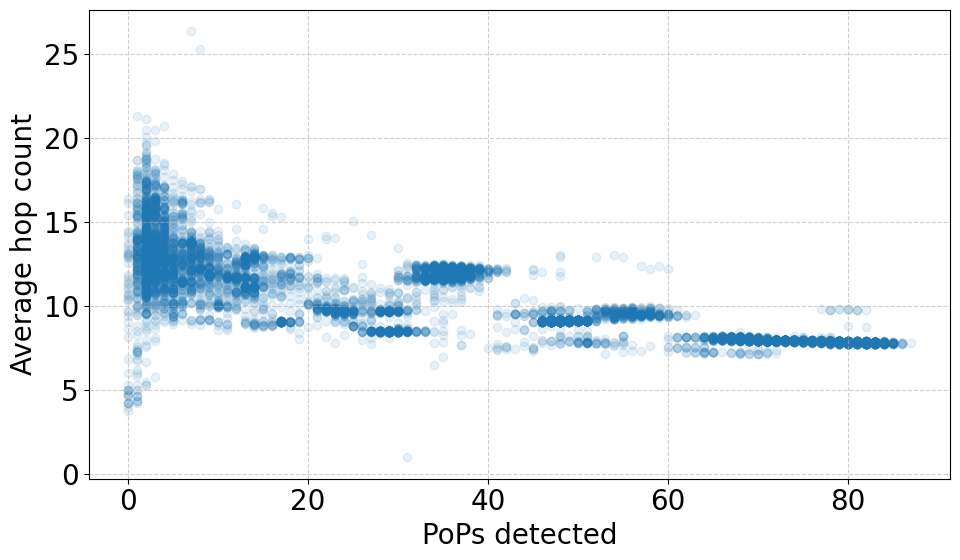

In [203]:
# plot number of hops against number of PoPs



# 1.get traceroute lengths of each VP, target pair
traceroute_lengths = df.groupby(['tx_hostname', 'prefix'])['hop_count'].first()

# 2. calculate average hop count per prefix
avg_hop_counts_per_prefix = traceroute_lengths.groupby(level='prefix').mean().rename('avg_hop_count')


# 3. get number of PoPs per prefix
site_counts_per_prefix = merged_df[['prefix', 'TR']].drop_duplicates(subset=['prefix']).set_index('prefix')['TR']

# 4. combine ttl lengths and number of PoPs
plot_data = pd.concat([avg_hop_counts_per_prefix, site_counts_per_prefix], axis=1, join='inner')
print(plot_data)

plt.figure(figsize=(10, 6))
plt.scatter(plot_data['TR'], plot_data['avg_hop_count'], alpha=0.1)

plt.xlabel("PoPs detected")
plt.ylabel("Average hop count")

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

plt.savefig("hop_count_scatter.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

In [223]:
# plot latency against hop count

# 1.get traceroute lengths of each VP, target pair
traceroute_lengths = df.groupby(['tx_hostname', 'prefix'])['hop_count'].first()
avg_hop_counts_per_prefix = traceroute_lengths.groupby(level='prefix').mean().rename('avg_hop_count')

# 2. get RTT towards each PoP
pop_rtts = df.groupby(['tx_hostname', 'prefix'])['pop_rtt'].first()
avg_rtts_per_prefix = pop_rtts.groupby(level='prefix').mean().rename('avg_pop_rtt') # Calculate average RTT

# 4. combine ttl lengths and average rtt
plot_data = pd.concat([avg_hop_counts_per_prefix, avg_rtts_per_prefix], axis=1, join='inner')
print(plot_data)

                avg_hop_count  avg_pop_rtt
prefix                                    
1.0.0.0/24           7.802920     9.607292
1.1.1.0/24           7.703846    10.929742
1.10.10.0/24        14.062500   208.615852
1.12.0.0/24         14.458333   102.723392
1.12.12.0/24        13.632979    90.069745
...                       ...          ...
99.83.254.0/24      11.747368    15.629442
99.83.255.0/24      11.773196    15.709402
99.99.97.0/24       12.940171    75.167333
99.99.98.0/24       13.879310    85.667448
99.99.99.0/24       13.923077    82.285115

[13735 rows x 2 columns]


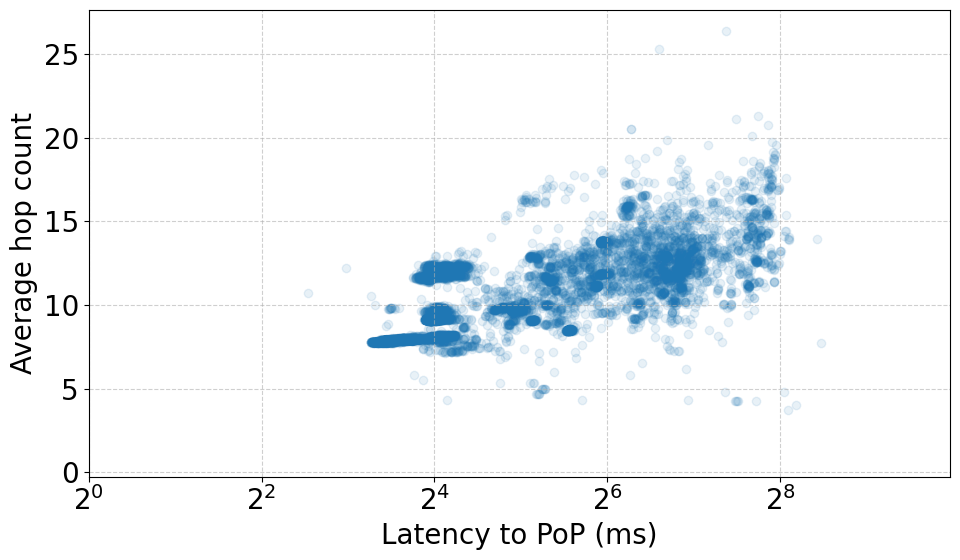

In [222]:
plt.figure(figsize=(10, 6))
plt.scatter(plot_data['avg_pop_rtt'], plot_data['avg_hop_count'], alpha=0.1)

plt.xlabel("Latency to PoP (ms)")
plt.xscale('log', base=2)
plt.xlim(1, 1000)

plt.ylabel("Average hop count")

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

plt.savefig("latency_hop_count.pdf", bbox_inches='tight', pad_inches=0)

plt.show()